
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_8258/1883313200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


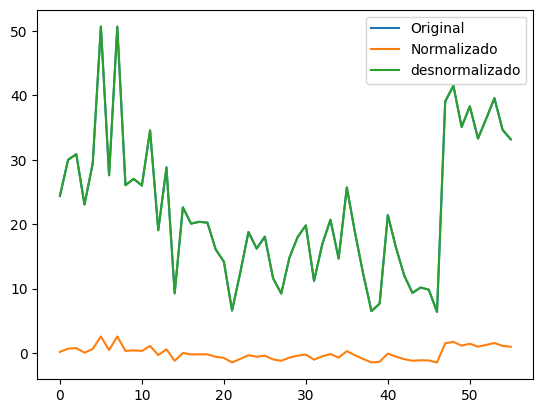

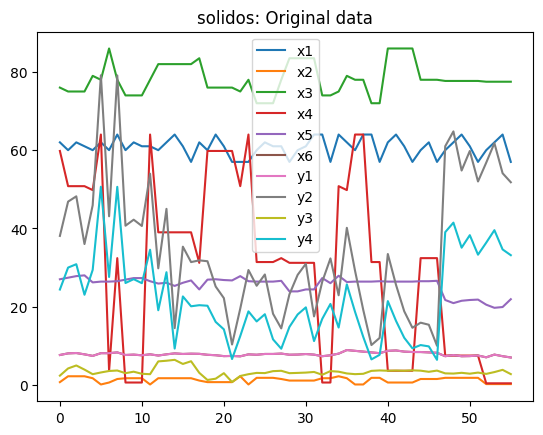

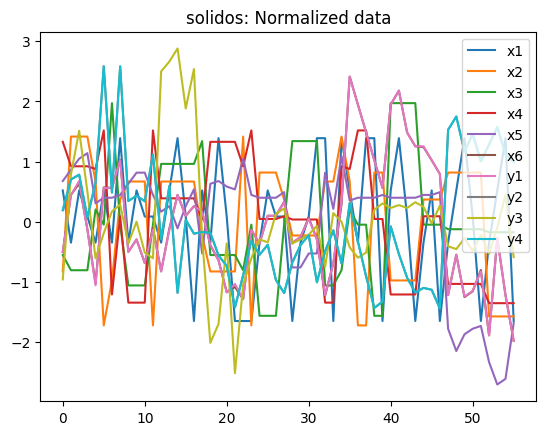

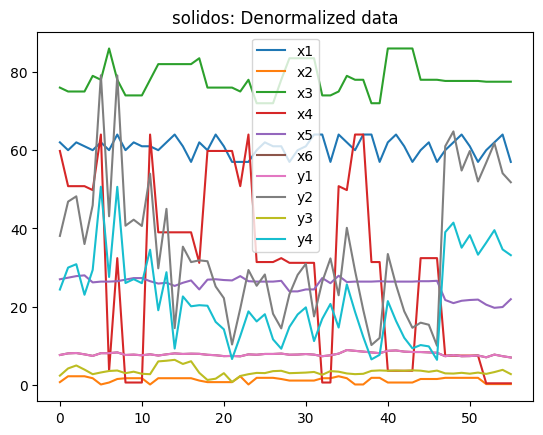

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y4"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y4")
test_out_scaler()
show_norm(label="solidos")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-18 00:03:37.276148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 00:03:37.283485: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 00:03:37.317127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 00:03:37.317158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 00:03:37.318477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++


Elapsed time:  0.6481183690000307
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.15301585100007742
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.1741072360000544
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.12975951299995359
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.17673192899997048
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.1341665989999683
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Elapsed time:  0.14938668399997823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+

2024-05-18 00:03:57.089590: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_1] | 19 ++++++++++++++++++
Elapsed time:  0.1348653979999881
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 20 ++++++++++++++++++
Elapsed time:  0.12444718099993679
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_1] | 21 ++++++++++++++++++
Elapsed time:  0.13297542500004056
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 22 ++++++++++++++++++
Elapsed time:  0.12595020800006296
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 23 ++++++++++++++++++
Elapsed time:  0.16940637099992273
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_1] | 24 ++++++++++++++++++
Elapsed time:  0.1302236730000459
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_1] | 25 ++++++++++++++++++
Elapsed 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_2_0,0.806064,0.510416,0.599753,0.570872,23.388758,34.692377,37.383103,35.958601
model_1_2_1,0.818615,0.480427,0.561639,0.537454,21.875138,36.817478,40.942948,38.758876
model_1_2_2,0.827371,0.448352,0.524567,0.503648,20.819146,39.090303,44.405490,41.591567
model_1_2_17,0.828438,0.176816,0.178057,0.200327,20.690422,58.331643,76.769539,67.008300
model_1_2_16,0.829773,0.184060,0.190065,0.209868,20.529448,57.818291,75.648003,66.208743
model_1_2_15,0.831167,0.192216,0.203266,0.220444,20.361343,57.240360,74.415038,65.322561
model_1_2_14,0.832605,0.201405,0.217759,0.232160,20.187874,56.589221,73.061330,64.340802
model_1_2_3,0.833281,0.416413,0.488856,0.470618,20.106310,41.353531,47.740850,44.359328
model_1_2_13,0.834066,0.211762,0.233647,0.245131,20.011690,55.855292,71.577406,63.253934
model_1_2_12,0.835519,0.223444,0.251035,0.259481,19.836438,55.027552,69.953378,62.051470


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.21082551599999988
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.17017643600001975
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.13432873499994002
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.14226311100003386
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.14526789899991854
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  0.19987808999997014
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Elapsed time:  0.12504

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_0,0.932572,0.846243,0.972815,0.915328,8.131835,15.737555,3.521851,9.988988
model_1_3_24,0.939535,0.746436,0.833140,0.797303,7.292086,25.953232,21.617132,23.912714
model_1_3_1,0.939773,0.840901,0.972273,0.912594,7.263412,16.284380,3.592095,10.311540
model_1_3_23,0.940006,0.747966,0.835265,0.799105,7.235282,25.796561,21.341770,23.700189
model_1_3_22,0.940519,0.749658,0.837616,0.801097,7.173474,25.623471,21.037185,23.465219
model_1_3_21,0.941075,0.751524,0.840215,0.803297,7.106423,25.432411,20.700467,23.205614
model_1_3_20,0.941676,0.753583,0.843086,0.805726,7.033946,25.221674,20.328589,22.919046
model_1_3_19,0.942323,0.755852,0.846254,0.808406,6.955918,24.989420,19.918205,22.602966
model_1_3_18,0.943016,0.758350,0.849745,0.811357,6.872330,24.733729,19.465829,22.254717
model_1_3_17,0.943754,0.761097,0.853590,0.814606,6.783321,24.452566,18.967806,21.871502


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.1551480419999507
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.17728974400006337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.12780964599994604
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.12596554699996432
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.12758894500007045
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.12638368099999298
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.1282524

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.952358,0.995532,0.769320,0.872127,5.745672,0.267546,18.855541,9.014838
model_1_4_1,0.956653,0.992070,0.767579,0.869621,5.227717,0.474857,18.997838,9.191554
model_1_4_2,0.959906,0.987980,0.764894,0.866317,4.835408,0.719727,19.217272,9.424454
model_1_4_3,0.962329,0.983529,0.761474,0.862449,4.543130,0.986263,19.496858,9.697131
model_1_4_24,0.963467,0.923060,0.687732,0.795023,4.405931,4.607114,25.524396,14.450541
model_1_4_23,0.963683,0.924173,0.689431,0.796451,4.379878,4.540480,25.385527,14.349914
model_1_4_22,0.963915,0.925400,0.691292,0.798017,4.351895,4.467032,25.233437,14.239458
model_1_4_4,0.964095,0.978912,0.757504,0.858207,4.330114,1.262747,19.821375,9.996219
model_1_4_21,0.964163,0.926751,0.693328,0.799736,4.321966,4.386093,25.067046,14.118306
model_1_4_20,0.964427,0.928239,0.695549,0.801617,4.290169,4.297002,24.885508,13.985710


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.13128645100005087
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.12881731400000263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.15596958400010408
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.13014468900007614
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.1673889500000314
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.14802497400000902
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.1326435

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.969386,0.979543,0.999659,0.990404,3.692109,2.369971,0.046599,1.276620
model_1_5_1,0.973948,0.975846,0.999139,0.988449,3.141906,2.798368,0.117540,1.536801
model_1_5_2,0.977446,0.971904,0.998440,0.986294,2.720014,3.254980,0.213127,1.823520
model_1_5_3,0.980109,0.967880,0.997634,0.984049,2.398841,3.721223,0.323146,2.122128
model_1_5_4,0.982117,0.963881,0.996775,0.981790,2.156704,4.184463,0.440529,2.422612
model_1_5_5,0.983611,0.959982,0.995897,0.979569,1.976520,4.636227,0.560393,2.718187
model_1_5_6,0.984703,0.956230,0.995026,0.977419,1.844777,5.070860,0.679343,3.004264
model_1_5_24,0.985178,0.919714,0.986082,0.956263,1.787516,9.301392,1.900904,5.818809
model_1_5_23,0.985304,0.920571,0.986293,0.956760,1.772396,9.202056,1.872198,5.752711
model_1_5_22,0.985437,0.921517,0.986525,0.957308,1.756359,9.092482,1.840489,5.679779


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.13175790400009646
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.12804395699981796
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.1300460560000829
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.12416457800009084
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.1903260889998819
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.17115699500004666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.17017992

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.987862,0.994752,0.999195,0.997178,1.463884,0.383378,0.074820,0.238174
model_1_6_1,0.989990,0.994284,0.999048,0.996887,1.207257,0.417552,0.088491,0.262700
model_1_6_2,0.991672,0.993598,0.998818,0.996454,1.004380,0.467667,0.109848,0.299281
model_1_6_3,0.992997,0.992762,0.998534,0.995924,0.844573,0.528741,0.136167,0.344000
model_1_6_4,0.994036,0.991829,0.998219,0.995333,0.719217,0.596866,0.165445,0.393845
model_1_6_5,0.994848,0.990842,0.997888,0.994709,0.621371,0.668987,0.196201,0.446500
model_1_6_6,0.995477,0.989832,0.997553,0.994073,0.545450,0.742777,0.227360,0.500228
model_1_6_7,0.995962,0.988823,0.997221,0.993439,0.486969,0.816464,0.258167,0.553736
model_1_6_8,0.996332,0.987833,0.996899,0.992819,0.442316,0.888739,0.288080,0.606076
model_1_6_9,0.996612,0.986876,0.996591,0.992220,0.408598,0.958662,0.316743,0.656583


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.1786247390000426
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.1273297679999814
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.12623796699995182
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.1249305500000446
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.12660161799999514
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.1606615809998857
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.1692369599

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_24,0.997156,0.987175,0.982979,0.985939,0.342936,0.933179,1.344037,1.126524
model_1_7_23,0.997176,0.987201,0.983184,0.986046,0.340545,0.931329,1.327811,1.117909
model_1_7_22,0.997198,0.987229,0.983411,0.986165,0.337936,0.929297,1.309895,1.108402
model_1_7_21,0.997221,0.987259,0.983661,0.986295,0.335100,0.927076,1.290154,1.097936
model_1_7_20,0.997247,0.987293,0.983937,0.986439,0.332020,0.924637,1.268383,1.086400
model_1_7_19,0.997275,0.987330,0.984240,0.986598,0.328688,0.921968,1.244419,1.073709
model_1_7_18,0.997304,0.987370,0.984574,0.986772,0.325098,0.919058,1.218058,1.059764
model_1_7_17,0.997336,0.987413,0.984941,0.986963,0.321248,0.915885,1.189122,1.044467
model_1_7_0,0.997360,0.988441,0.997069,0.993082,0.318351,0.841103,0.231470,0.554217
model_1_7_16,0.997370,0.987460,0.985342,0.987172,0.317144,0.912451,1.157401,1.027721


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  1.4434819379998771
Stopped at epoch:  77
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.28978550199985875
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.14870958400001655
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.20337220999999772
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.12734598199995162
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.1302976919998855
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.309143

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_23,0.998917,0.998708,0.985233,0.996735,0.130632,0.269573,0.611157,0.430319
model_1_8_24,0.998917,0.998708,0.985233,0.996735,0.130632,0.269573,0.611157,0.430319
model_1_8_22,0.998917,0.998708,0.985233,0.996735,0.130632,0.269572,0.611157,0.430318
model_1_8_21,0.998917,0.998708,0.985233,0.996735,0.130632,0.269571,0.611158,0.430318
model_1_8_20,0.998917,0.998708,0.985233,0.996735,0.130632,0.269571,0.611156,0.430317
model_1_8_18,0.998917,0.998708,0.985233,0.996735,0.130632,0.269571,0.611155,0.430317
model_1_8_19,0.998917,0.998708,0.985233,0.996735,0.130631,0.269570,0.611153,0.430315
model_1_8_15,0.998917,0.998708,0.985233,0.996735,0.130631,0.269569,0.611154,0.430315
model_1_8_16,0.998917,0.998708,0.985233,0.996735,0.130631,0.269569,0.611154,0.430315
model_1_8_17,0.998917,0.998708,0.985233,0.996735,0.130631,0.269569,0.611154,0.430315


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.17150043299989193
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.3287281009997969
Stopped at epoch:  17
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.14691977799998313
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.12990835499999775
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.125931896000111
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.13149426499990113
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.16675723

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.998917,0.999974,0.995236,0.998523,0.130632,0.003758,0.348354,0.165921
model_1_9_24,0.999325,0.999390,0.993565,0.997617,0.081360,0.087288,0.470551,0.267647
model_1_9_23,0.999327,0.999395,0.993576,0.997623,0.081161,0.086617,0.469734,0.266907
model_1_9_22,0.999329,0.999400,0.993589,0.997631,0.080944,0.085874,0.468832,0.266090
model_1_9_21,0.999331,0.999406,0.993602,0.997639,0.080709,0.085053,0.467832,0.265185
model_1_9_20,0.999333,0.999412,0.993617,0.997648,0.080454,0.084146,0.466731,0.264186
model_1_9_19,0.999335,0.999419,0.993634,0.997657,0.080179,0.083142,0.465515,0.263082
model_1_9_18,0.999338,0.999427,0.993652,0.997668,0.079882,0.082036,0.464170,0.261863
model_1_9_17,0.999340,0.999435,0.993673,0.997680,0.079566,0.080816,0.462691,0.260522
model_1_9_16,0.999343,0.999445,0.993695,0.997693,0.079230,0.079471,0.461062,0.259043


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.3271786999998767
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.14471530299988444
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.12579525399996783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.12460779999992155
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.1302016189999904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.1271389349999481
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_1_7,0.802554,0.655274,-0.547509,0.506267,23.812063,61.228147,79.212802,69.691514
model_2_1_0,0.807680,0.810913,0.182288,0.734491,23.193875,33.584538,41.856460,37.477207
model_2_1_6,0.808417,0.679093,-0.457819,0.537440,23.104971,56.997612,74.621815,65.291355
model_2_1_5,0.813554,0.703147,-0.360521,0.570068,22.485482,52.725222,69.641398,60.685775
model_2_1_1,0.815653,0.792430,0.074761,0.703828,22.232327,36.867316,47.360465,41.805268
model_2_1_4,0.817502,0.727002,-0.256597,0.603695,22.009303,48.488269,64.321810,55.939347
model_2_1_2,0.819337,0.772113,-0.036298,0.671341,21.787990,40.475960,53.045277,46.390933
model_2_1_3,0.819671,0.750160,-0.147729,0.637701,21.747690,44.375069,58.749149,51.139342


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Elapsed time:  0.1354167280001093
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Elapsed time:  0.14377754500014817
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Elapsed time:  0.12651958600008584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Elapsed time:  0.1598615120001341
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Elapsed time:  0.14593854099985037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Elapsed time:  0.13456074900000203
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Elapsed time:  0.12854285

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_2_10,0.803896,0.373114,-0.872653,-0.255503,23.650176,33.796491,117.232156,73.060333
model_2_2_9,0.808736,0.398231,-0.793237,-0.202980,23.066439,32.442433,112.260524,70.003888
model_2_2_8,0.813503,0.426000,-0.708420,-0.146421,22.491642,30.945363,106.950798,66.712626
model_2_2_0,0.813824,0.720997,0.097655,0.406343,22.452907,15.041527,56.488769,34.546111
model_2_2_7,0.818039,0.456552,-0.618349,-0.085838,21.944559,29.298240,101.312178,63.187152
model_2_2_6,0.822136,0.489920,-0.523326,-0.021366,21.450462,27.499298,95.363551,59.435417
model_2_2_1,0.822480,0.684573,-0.002984,0.337530,21.408989,17.005199,62.788968,38.550502
model_2_2_5,0.825514,0.525983,-0.423857,0.046678,21.043062,25.555083,89.136551,55.475774
model_2_2_2,0.827019,0.645011,-0.108302,0.264808,20.861508,19.138073,69.382126,42.782333
model_2_2_4,0.827803,0.564378,-0.320705,0.117731,20.766982,23.485154,82.678980,51.341072


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.15827272999990782
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.1312205520000589
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.14000442900010057
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.1374712310000632
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.12885539000012614
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.17765982099990651
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.17665044

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_0,0.835362,0.819030,0.756692,0.807916,19.855361,18.004634,14.389641,16.303461
model_2_3_1,0.861377,0.835018,0.763140,0.819952,16.717965,16.413987,14.008275,15.281887
model_2_3_2,0.881728,0.845034,0.763713,0.826356,14.263666,15.417525,13.974352,14.738385
model_2_3_3,0.897523,0.850167,0.759942,0.828305,12.358800,14.906799,14.197374,14.572952
model_2_3_4,0.909643,0.851284,0.752939,0.826701,10.897058,14.795693,14.611579,14.709051
model_2_3_5,0.918802,0.849100,0.743604,0.822285,9.792464,15.012943,15.163664,15.083870
model_2_3_6,0.925581,0.844232,0.732670,0.815679,8.974984,15.497277,15.810323,15.644592
model_2_3_24,0.926275,0.680721,0.563189,0.658637,8.891200,31.764991,25.833696,28.973793
model_2_3_23,0.927161,0.686347,0.567836,0.663653,8.784390,31.205175,25.558842,28.548077
model_2_3_22,0.928106,0.692498,0.572958,0.669149,8.670464,30.593302,25.255919,28.081593


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  0.13471037899989824
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.14849564300016027
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.12889974100016843
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.32392063799989046
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.1453997230000823
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.1355672780000532
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.17437798

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_4_0,0.935529,0.934398,0.827255,0.916893,7.775275,9.680261,9.973222,9.818125
model_2_4_1,0.942637,0.934882,0.819105,0.915339,6.918007,9.608833,10.443762,10.001740
model_2_4_2,0.948013,0.934332,0.809752,0.912824,6.269681,9.690037,10.983747,10.298842
model_2_4_3,0.952012,0.932962,0.799729,0.909614,5.787343,9.892114,11.562379,10.678121
model_2_4_4,0.954957,0.931109,0.789486,0.906033,5.432230,10.165579,12.153743,11.101186
model_2_4_5,0.957119,0.929097,0.779420,0.902388,5.171452,10.462398,12.734911,11.531815
model_2_4_6,0.958707,0.927139,0.769818,0.898884,4.979999,10.751409,13.289276,11.945699
model_2_4_7,0.959867,0.925332,0.760835,0.895624,4.840064,11.018046,13.807904,12.330920
model_2_4_8,0.960704,0.923705,0.752526,0.892637,4.739060,11.258127,14.287619,12.683770
model_2_4_24,0.961020,0.912189,0.686221,0.869774,4.700993,12.957460,18.115629,15.384834


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Elapsed time:  0.13786160100016787
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Elapsed time:  0.1373887699999159
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Elapsed time:  0.17085580100001607
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Elapsed time:  0.1350623959999666
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Elapsed time:  0.14707720600017637
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Elapsed time:  0.12862924099999873
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Elapsed time:  0.13464905

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.965931,0.989946,0.780367,0.939668,4.108703,1.071307,8.316138,4.480639
model_2_5_1,0.969740,0.989711,0.769373,0.936852,3.649317,1.096337,8.732416,4.689786
model_2_5_2,0.972679,0.989052,0.758708,0.933793,3.294916,1.166493,9.136261,4.916972
model_2_5_3,0.974931,0.988123,0.748479,0.930632,3.023360,1.265542,9.523543,5.151660
model_2_5_4,0.976641,0.987030,0.738761,0.927471,2.817073,1.381976,9.891531,5.386472
model_2_5_5,0.977926,0.985851,0.729594,0.924376,2.662093,1.507650,10.238596,5.616330
model_2_5_6,0.978878,0.984638,0.721003,0.921393,2.547337,1.636890,10.563894,5.837833
model_2_5_7,0.979569,0.983429,0.712992,0.918553,2.463992,1.765702,10.867232,6.048775
model_2_5_24,0.979810,0.971184,0.644311,0.892774,2.434861,3.070392,13.467760,7.963271
model_2_5_23,0.979899,0.971513,0.646006,0.893430,2.424163,3.035412,13.403587,7.914553


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.133866979000004
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.13153162300000076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.14472853500001293
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.1780812889999197
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.1363456750000296
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.13424978600005488
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.1316128650

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.981072,0.988107,0.925603,0.941370,2.282742,0.577418,12.102646,6.001055
model_2_6_1,0.982107,0.988153,0.927186,0.942565,2.157863,0.575160,11.845270,5.878741
model_2_6_2,0.982959,0.988098,0.928566,0.943584,2.055187,0.577856,11.620713,5.774495
model_2_6_3,0.983660,0.987971,0.929773,0.944454,1.970629,0.584037,11.424378,5.685374
model_2_6_4,0.984238,0.987794,0.930831,0.945201,1.900869,0.592593,11.252316,5.608933
model_2_6_5,0.984716,0.987587,0.931759,0.945843,1.843217,0.602674,11.101262,5.543186
model_2_6_6,0.985112,0.987360,0.932576,0.946398,1.795480,0.613655,10.968372,5.486463
model_2_6_7,0.985441,0.987126,0.933296,0.946877,1.755869,0.625061,10.851253,5.437386
model_2_6_8,0.985714,0.986889,0.933932,0.947293,1.722932,0.636546,10.747848,5.394805
model_2_6_9,0.985941,0.986656,0.934493,0.947655,1.695488,0.647862,10.656440,5.357781


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.13520513999992545
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.12822205800011943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.12814224800013108
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.13071350399991388
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.1576218269999572
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.17960275299992645
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.1342905

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_24,0.979383,0.859637,0.990390,0.951994,2.486453,13.404263,2.271569,8.165348
model_2_7_23,0.979769,0.862392,0.990572,0.952932,2.439805,13.141122,2.228436,8.005740
model_2_7_22,0.980192,0.865418,0.990773,0.953962,2.388843,12.852217,2.181120,7.830524
model_2_7_21,0.980653,0.868735,0.990992,0.955092,2.333282,12.535456,2.129292,7.638437
model_2_7_20,0.981154,0.872365,0.991232,0.956327,2.272868,12.188774,2.072615,7.428229
model_2_7_19,0.981697,0.876331,0.991493,0.957677,2.207360,11.810029,2.010772,7.198614
model_2_7_18,0.982284,0.880653,0.991778,0.959149,2.136584,11.397238,1.943444,6.948393
model_2_7_17,0.982915,0.885353,0.992087,0.960748,2.060410,10.948422,1.870324,6.676376
model_2_7_16,0.983592,0.890448,0.992422,0.962481,1.978825,10.461932,1.791166,6.381571
model_2_7_15,0.984312,0.895951,0.992784,0.964353,1.891924,9.936324,1.705775,6.063124


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.23867029300004106
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.1737401030000001
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.12556614200002514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.16923656200015103
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.13613771499990435
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.15496372300003713
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.1554594

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.987002,0.975427,0.984238,0.978410,1.567527,2.233300,0.497513,1.416459
model_2_8_1,0.988425,0.973627,0.980172,0.976169,1.395933,2.396908,0.625880,1.563483
model_2_8_2,0.989476,0.971678,0.975768,0.973742,1.269143,2.574048,0.764888,1.722679
model_2_8_24,0.989867,0.943226,0.914511,0.939007,1.221995,5.159904,2.698456,4.001576
model_2_8_23,0.989951,0.943717,0.915518,0.939595,1.211972,5.115261,2.666644,3.962970
model_2_8_22,0.990040,0.944258,0.916631,0.940244,1.201147,5.066090,2.631529,3.920414
model_2_8_21,0.990137,0.944854,0.917858,0.940958,1.189501,5.011968,2.592796,3.873535
model_2_8_3,0.990236,0.969650,0.971204,0.971222,1.177520,2.758361,0.908945,1.888048
model_2_8_20,0.990240,0.945509,0.919210,0.941745,1.177026,4.952420,2.550122,3.821927
model_2_8_19,0.990350,0.946228,0.920699,0.942610,1.163742,4.887009,2.503136,3.765186


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.13351547699994626
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.1990849439998783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.1325699330000134
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.13754799100001946
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.12680733299998792
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.12709416200004853
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.13254964

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.990730,0.938372,0.999566,0.966911,1.118011,3.948882,0.023255,2.101528
model_2_9_1,0.991404,0.937426,0.999556,0.966402,1.036623,4.009498,0.023764,2.133858
model_2_9_2,0.991930,0.936502,0.999428,0.965858,0.973243,4.068708,0.030619,2.168431
model_2_9_3,0.992337,0.935611,0.999218,0.965299,0.924184,4.125777,0.041879,2.203943
model_2_9_4,0.992649,0.934761,0.998953,0.964740,0.886491,4.180224,0.056075,2.239448
model_2_9_5,0.992887,0.933957,0.998654,0.964192,0.857795,4.231738,0.072089,2.274256
model_2_9_6,0.993066,0.933202,0.998337,0.963662,0.836199,4.280132,0.089095,2.307879
model_2_9_7,0.993199,0.932496,0.998013,0.963157,0.820190,4.325369,0.106476,2.340008
model_2_9_8,0.993296,0.931840,0.997689,0.962678,0.808554,4.367412,0.123782,2.370410
model_2_9_24,0.993338,0.926408,0.994447,0.958490,0.803394,4.715459,0.297481,2.636411


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.399395037999966
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.2878658980000637
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.12743360700005724
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.12675420499999746
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.1271736480000527
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.14073737000012443
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.821488,0.551936,0.841746,0.834963,21.528636,26.750162,14.299877,20.891205
model_3_3_1,0.839943,0.501216,0.828973,0.818009,19.302892,29.778179,15.454000,23.037389
model_3_3_2,0.853619,0.449647,0.814562,0.800291,17.653570,32.856990,16.756231,25.280162
model_3_3_3,0.863652,0.398822,0.799822,0.782649,16.443578,35.891308,18.088114,27.513334
model_3_3_4,0.870903,0.349648,0.785577,0.765586,15.569090,38.827049,19.375279,29.673275
model_3_3_5,0.876034,0.302702,0.772292,0.749401,14.950396,41.629839,20.575719,31.722018
model_3_3_22,0.876291,-0.108623,0.679823,0.615636,14.919390,66.186559,28.931296,48.654671
model_3_3_21,0.876986,-0.098657,0.681619,0.618728,14.835573,65.591619,28.768935,48.263297
model_3_3_20,0.877719,-0.087636,0.683624,0.622153,14.747139,64.933596,28.587802,47.829693
model_3_3_19,0.878486,-0.075446,0.685863,0.625949,14.654596,64.205833,28.385522,47.349216


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.13798510500009797
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.13522548800006007
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.13001592999989953
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.12909464700010176
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.12975494800002707
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.33376617799990527
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.182984

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.894757,0.985469,0.792580,0.878924,12.692348,1.047726,22.741036,11.256342
model_3_4_1,0.908761,0.980483,0.791402,0.876223,11.003405,1.407193,22.870198,11.507430
model_3_4_24,0.914080,0.579144,0.653569,0.634949,10.361925,30.344344,37.981858,33.938468
model_3_4_23,0.915182,0.589040,0.655617,0.640149,10.229041,29.630825,37.757287,33.455042
model_3_4_22,0.916374,0.599829,0.657906,0.645848,10.085304,28.852961,37.506389,32.925163
model_3_4_21,0.917658,0.611564,0.660462,0.652085,9.930416,28.006841,37.226152,32.345341
model_3_4_20,0.919036,0.624297,0.663315,0.658896,9.764253,27.088746,36.913312,31.712071
model_3_4_2,0.919120,0.971150,0.786779,0.869826,9.754148,2.080137,23.377008,12.102194
model_3_4_19,0.920507,0.638077,0.666499,0.666321,9.586906,26.095235,36.564262,31.021836
model_3_4_18,0.922066,0.652941,0.670047,0.674393,9.398813,25.023475,36.175256,30.271372


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.13676114599979883
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.15066862399999081
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.1757398209999792
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.13048500600007173
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.17118657200012422
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.12700904500002252
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.1735938

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.923869,0.998875,0.801560,0.901930,9.181368,0.127565,24.575447,11.632451
model_3_5_1,0.931133,0.997006,0.792339,0.896453,8.305398,0.339603,25.717486,12.282136
model_3_5_24,0.932609,0.930923,0.613830,0.775292,8.127321,7.834744,47.824583,26.653492
model_3_5_23,0.933182,0.932283,0.616806,0.777443,8.058325,7.680416,47.456007,26.398341
model_3_5_22,0.933801,0.933774,0.620085,0.779808,7.983601,7.511373,47.049997,26.117785
model_3_5_21,0.934470,0.935404,0.623692,0.782406,7.902960,7.326523,46.603222,25.809676
model_3_5_20,0.935188,0.937182,0.627658,0.785254,7.816294,7.124768,46.112133,25.471763
model_3_5_19,0.935957,0.939120,0.632011,0.788374,7.723604,6.905016,45.573007,25.101718
model_3_5_2,0.936405,0.994404,0.781831,0.889972,7.669593,0.634735,27.018819,13.050775
model_3_5_18,0.936774,0.941225,0.636783,0.791785,7.625051,6.666223,44.982036,24.697194


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.4945343150000099
Stopped at epoch:  12
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.18126871999993455
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.1303969349999079
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.12940183499995328
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.14721909999980198
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.12799307499994939
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.2684847

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.978906,0.992065,0.833259,0.978773,2.543995,1.678097,4.436773,2.976297
model_3_6_1,0.981148,0.990766,0.834098,0.977810,2.273554,1.952865,4.414450,3.111258
model_3_6_2,0.982878,0.989449,0.834393,0.976785,2.064872,2.231275,4.406613,3.254963
model_3_6_3,0.984202,0.988145,0.834281,0.975734,1.905191,2.507008,4.409584,3.402338
model_3_6_4,0.985205,0.986875,0.833873,0.974684,1.784284,2.775557,4.420448,3.549623
model_3_6_5,0.985954,0.985654,0.833255,0.973653,1.693948,3.033763,4.436884,3.694055
model_3_6_6,0.986504,0.984492,0.832495,0.972657,1.627624,3.279533,4.457115,3.833689
model_3_6_24,0.986811,0.973611,0.820247,0.962875,1.590628,5.580580,4.782999,5.205248
model_3_6_23,0.986871,0.973859,0.820597,0.963104,1.583340,5.528245,4.773687,5.173159
model_3_6_7,0.986898,0.983395,0.831646,0.971705,1.580072,3.511584,4.479709,3.967172


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.1351731969998582
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.1319364170001336
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.14874542600000495
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.14683740499981468
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.17348161199993228
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.15830692700001237
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.13022142

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_24,0.983719,0.923234,0.813569,0.895144,1.963449,5.830584,7.130705,6.442406
model_3_7_23,0.983990,0.924613,0.816793,0.896991,1.930812,5.725850,7.007396,6.328930
model_3_7_22,0.984285,0.926128,0.820337,0.899021,1.895184,5.610738,6.871845,6.204200
model_3_7_21,0.984607,0.927792,0.824227,0.901249,1.856383,5.484379,6.723059,6.067287
model_3_7_20,0.984957,0.929616,0.828491,0.903692,1.814226,5.345831,6.559956,5.917184
model_3_7_19,0.985335,0.931612,0.833157,0.906366,1.768578,5.194229,6.381494,5.752942
model_3_7_18,0.985744,0.933793,0.838253,0.909286,1.719314,5.028606,6.186572,5.573531
model_3_7_17,0.986183,0.936169,0.843806,0.912468,1.666386,4.848122,5.974173,5.378028
model_3_7_16,0.986652,0.938753,0.849844,0.915927,1.609786,4.651873,5.743247,5.165461
model_3_7_15,0.987151,0.941554,0.856387,0.919678,1.549627,4.439079,5.492972,4.935028


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.13968676000013147
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.13340208699992218
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.1465556859998287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.126764736000041
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.12877839299994776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.17262170800017884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.147042005

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.986442,0.926907,0.998884,0.990640,1.635045,1.785522,0.112020,0.997992
model_3_8_1,0.988564,0.929610,0.998361,0.990736,1.379243,1.719497,0.164564,0.987764
model_3_8_2,0.990204,0.930012,0.997765,0.990521,1.181419,1.709688,0.224379,1.010719
model_3_8_3,0.991461,0.928685,0.997130,0.990079,1.029782,1.742099,0.288174,1.057899
model_3_8_4,0.992414,0.926090,0.996479,0.989475,0.914825,1.805494,0.353532,1.122217
model_3_8_5,0.993127,0.922592,0.995830,0.988763,0.828895,1.890944,0.418704,1.198125
model_3_8_6,0.993650,0.918482,0.995195,0.987984,0.765835,1.991341,0.482441,1.281271
model_3_8_24,0.993869,0.854795,0.988791,0.977421,0.739365,3.547090,1.125544,2.407539
model_3_8_23,0.993930,0.856628,0.988942,0.977711,0.731989,3.502325,1.110315,2.376673
model_3_8_22,0.993995,0.858635,0.989110,0.978028,0.724172,3.453296,1.093514,2.342811


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.13371480499995414
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.19040720699990743
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.13569710700016913
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.16171291000000565
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.13240288400015743
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.12937953999994534
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.215473

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.994695,0.991800,0.994353,0.992653,0.639767,0.931421,0.361401,0.663176
model_3_9_1,0.995322,0.991652,0.993836,0.992382,0.564158,0.948214,0.394504,0.687645
model_3_9_2,0.995790,0.991329,0.993292,0.991985,0.507699,0.984929,0.429308,0.723460
model_3_9_24,0.996004,0.980644,0.986246,0.982516,0.481912,2.198637,0.880252,1.578221
model_3_9_23,0.996042,0.980873,0.986359,0.982706,0.477351,2.172565,0.873048,1.561028
model_3_9_22,0.996083,0.981125,0.986483,0.982915,0.472431,2.143964,0.865091,1.542141
model_3_9_21,0.996126,0.981401,0.986620,0.983145,0.467148,2.112644,0.856319,1.521432
model_3_9_3,0.996132,0.990875,0.992740,0.991498,0.466444,1.036499,0.464638,0.767388
model_3_9_20,0.996173,0.981702,0.986771,0.983396,0.461500,2.078392,0.846646,1.498747
model_3_9_19,0.996223,0.982031,0.986938,0.983671,0.455498,2.041010,0.835977,1.473936


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.3457735730000877
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.12942467800007762
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.1268932279999717
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.1306586740001876
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.12846137099995758
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.14306340300004194
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_0,0.802329,0.654876,-0.008910,0.481967,23.839158,26.764096,120.257142,70.760824
model_4_2_1,0.805033,0.647041,-0.010322,0.479032,23.513099,27.371702,120.425520,71.161734
model_4_2_2,0.807115,0.639782,-0.011560,0.476342,23.261933,27.934606,120.573005,71.529147
model_4_2_3,0.808707,0.633084,-0.012644,0.473883,23.070053,28.454040,120.702234,71.864955
model_4_2_4,0.809910,0.626925,-0.013592,0.471643,22.924920,28.931652,120.815264,72.170999
model_4_2_5,0.810808,0.621278,-0.014424,0.469604,22.816612,29.369611,120.914369,72.449497
model_4_2_6,0.811467,0.616112,-0.015154,0.467752,22.737179,29.770181,121.001413,72.702525
model_4_2_7,0.811939,0.611398,-0.015795,0.466072,22.680256,30.135805,121.077765,72.932021
model_4_2_8,0.812266,0.607101,-0.016358,0.464549,22.640832,30.468970,121.144905,73.139998
model_4_2_9,0.812480,0.603193,-0.016855,0.463170,22.614914,30.772098,121.204121,73.328344


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.13500971199982814
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.21904526000002988
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.1294825630000105
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.12801419099992017
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.13274699299995518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.12832437800011576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.1263880

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.844720,0.906332,0.966403,0.935216,18.726861,9.127516,3.368602,6.417439
model_4_3_1,0.868372,0.898284,0.942047,0.919424,15.874400,9.911737,5.810676,7.981826
model_4_3_2,0.885173,0.888543,0.909777,0.898981,13.848215,10.860901,9.046253,10.006949
model_4_3_24,0.889627,0.733457,0.369365,0.560808,13.310968,25.973360,63.230648,43.506201
model_4_3_23,0.890783,0.735561,0.378491,0.566251,13.171610,25.768252,62.315656,42.967030
model_4_3_22,0.892030,0.737889,0.388546,0.572252,13.021169,25.541482,61.307556,42.372576
model_4_3_21,0.893372,0.740461,0.399613,0.578863,12.859413,25.290825,60.197882,41.717675
model_4_3_20,0.894807,0.743304,0.411783,0.586141,12.686297,25.013775,58.977618,40.996760
model_4_3_19,0.896335,0.746448,0.425153,0.594147,12.502000,24.707381,57.637105,40.203722
model_4_3_3,0.896747,0.877157,0.872913,0.875492,12.452299,11.970413,12.742400,12.333701


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.18080317099997956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.13102264200006175
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.1303128250001464
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.126030240000091
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.12715705000005073
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.12588262999997823
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.128520296

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.910291,0.975930,0.993745,0.985537,10.818974,3.636216,0.198187,2.018320
model_4_4_1,0.926468,0.975683,0.989045,0.984893,8.867975,3.673564,0.347064,2.108152
model_4_4_2,0.939126,0.974312,0.982502,0.983408,7.341436,3.880688,0.554374,2.315364
model_4_4_3,0.949018,0.972191,0.974971,0.981388,6.148406,4.201170,0.792981,2.597317
model_4_4_4,0.956735,0.969589,0.967038,0.979049,5.217751,4.594208,1.044322,2.923673
model_4_4_5,0.962738,0.966703,0.959066,0.976544,4.493804,5.030230,1.296885,3.273362
model_4_4_6,0.967389,0.963674,0.951253,0.973973,3.932945,5.487829,1.544417,3.632106
model_4_4_7,0.970971,0.960604,0.943689,0.971405,3.500910,5.951659,1.784053,3.990432
model_4_4_8,0.973709,0.957564,0.936410,0.968886,3.170702,6.410809,2.014669,4.342037
model_4_4_9,0.975780,0.954607,0.929425,0.966445,2.920885,6.857543,2.235952,4.682676


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.21659674400007134
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.12854473599986704
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.15894495099996675
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.13041543300005287
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.16236990199990942
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.13184576899993772
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.128541

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.987169,0.989418,0.993888,0.991239,1.547411,1.911709,0.652596,1.319186
model_4_5_1,0.988493,0.988618,0.991663,0.989989,1.387732,2.056143,0.890198,1.507463
model_4_5_24,0.988995,0.981558,0.948581,0.971127,1.327172,3.331634,5.490531,4.347585
model_4_5_23,0.989088,0.981647,0.949258,0.971410,1.315989,3.315533,5.418268,4.305056
model_4_5_22,0.989188,0.981746,0.950005,0.971721,1.303870,3.297734,5.338533,4.258110
model_4_5_21,0.989297,0.981854,0.950828,0.972065,1.290783,3.278081,5.250607,4.206328
model_4_5_20,0.989414,0.981975,0.951735,0.972444,1.276708,3.256372,5.153752,4.149257
model_4_5_2,0.989446,0.987901,0.989027,0.988653,1.272828,2.185706,1.171719,1.708536
model_4_5_19,0.989539,0.982107,0.952733,0.972862,1.261640,3.232396,5.047172,4.086408
model_4_5_18,0.989672,0.982254,0.953830,0.973321,1.245610,3.205981,4.930016,4.017291


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.2730184819999977
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.13306098000020938
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.12880083599998216
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.12707067499991354
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.12647751600002266
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.1318032700000913
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.1272951

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.995263,0.985691,0.993306,0.989227,0.571275,3.000012,0.616744,1.878474
model_4_6_23,0.995280,0.985746,0.993333,0.989269,0.569290,2.988389,0.614241,1.871143
model_4_6_22,0.995297,0.985808,0.993363,0.989316,0.567124,2.975528,0.611469,1.863029
model_4_6_21,0.995317,0.985876,0.993396,0.989367,0.564767,2.961308,0.608406,1.854060
model_4_6_20,0.995338,0.985951,0.993433,0.989424,0.562201,2.945546,0.605012,1.844118
model_4_6_19,0.995361,0.986034,0.993474,0.989487,0.559428,2.928149,0.601267,1.833146
model_4_6_18,0.995386,0.986125,0.993519,0.989556,0.556436,2.908923,0.597125,1.821018
model_4_6_17,0.995413,0.986227,0.993568,0.989633,0.553219,2.887685,0.592546,1.807620
model_4_6_16,0.995441,0.986338,0.993623,0.989718,0.549786,2.864277,0.587497,1.792851
model_4_6_15,0.995472,0.986462,0.993684,0.989811,0.546137,2.838453,0.581931,1.776560


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.138851718000069
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.126242818000037
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.13117577999992136
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.12760079000008773
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.12814263900008882
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.15009683600010248
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.1619206360

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.996110,0.999770,0.999701,0.999729,0.469132,0.015319,0.032080,0.023207
model_4_7_1,0.996737,0.999425,0.999146,0.999261,0.393545,0.038324,0.091608,0.063399
model_4_7_24,0.996984,0.990710,0.982944,0.986146,0.363694,0.619014,1.828884,1.188364
model_4_7_23,0.997029,0.990861,0.983233,0.986378,0.358343,0.609005,1.797864,1.168468
model_4_7_22,0.997077,0.991026,0.983552,0.986633,0.352543,0.597984,1.763704,1.146558
model_4_7_21,0.997129,0.991208,0.983902,0.986914,0.346281,0.585858,1.726148,1.122465
model_4_7_20,0.997185,0.991408,0.984286,0.987222,0.339546,0.572523,1.684924,1.096006
model_4_7_2,0.997191,0.998980,0.998388,0.998633,0.338793,0.067935,0.172808,0.117287
model_4_7_19,0.997244,0.991628,0.984708,0.987561,0.332338,0.557894,1.639709,1.066983
model_4_7_18,0.997308,0.991868,0.985170,0.987931,0.324668,0.541855,1.590218,1.035203


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.14814143299986426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.12593857799993202
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.13103231499985668
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.1265851109999403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.1304022580000037
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.12715088499999183
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.15949760

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.997272,0.997079,0.993263,0.996047,0.329047,0.523061,0.683037,0.598344
model_4_8_1,0.997489,0.997125,0.993044,0.996007,0.302861,0.514709,0.705214,0.604359
model_4_8_2,0.997650,0.997159,0.992758,0.995938,0.283356,0.508761,0.734179,0.614840
model_4_8_3,0.997769,0.997182,0.992429,0.995848,0.269098,0.504671,0.767604,0.628405
model_4_8_24,0.997773,0.997120,0.987240,0.994174,0.268604,0.515613,1.293603,0.881726
model_4_8_23,0.997784,0.997124,0.987343,0.994209,0.267236,0.514930,1.283252,0.876494
model_4_8_22,0.997796,0.997128,0.987455,0.994247,0.265765,0.514205,1.271872,0.870754
model_4_8_21,0.997809,0.997133,0.987578,0.994289,0.264185,0.513409,1.259356,0.864443
model_4_8_20,0.997823,0.997138,0.987714,0.994334,0.262496,0.512550,1.245605,0.857517
model_4_8_19,0.997838,0.997143,0.987863,0.994385,0.260706,0.511635,1.230528,0.849938


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.17192388300009043
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.1270789339998828
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.14519206899990422
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.12886173399988365
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.12839135600006557
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.1346526879999601
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.12743330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.998098,0.997471,0.999781,0.998078,0.229324,0.413116,0.012864,0.224762
model_4_9_1,0.998348,0.997529,0.999537,0.998062,0.199286,0.403786,0.027238,0.226587
model_4_9_2,0.998536,0.997547,0.999235,0.998004,0.176561,0.400853,0.044956,0.233372
model_4_9_3,0.998677,0.997536,0.998898,0.997916,0.159605,0.402647,0.064785,0.243654
model_4_9_4,0.998780,0.997504,0.998541,0.997808,0.147178,0.407872,0.085776,0.256297
model_4_9_24,0.998808,0.996509,0.993925,0.995980,0.143725,0.570407,0.357185,0.470067
model_4_9_23,0.998818,0.996534,0.994020,0.996021,0.142502,0.566270,0.351590,0.465244
model_4_9_22,0.998829,0.996562,0.994125,0.996067,0.141188,0.561729,0.345423,0.459938
model_4_9_21,0.998841,0.996592,0.994241,0.996117,0.139786,0.556756,0.338639,0.454112
model_4_9_20,0.998853,0.996626,0.994367,0.996171,0.138301,0.551328,0.331178,0.447728


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.9690304759999435
Stopped at epoch:  26
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.1259132430000136
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.12728455499996016
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.17917450699997062
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.1257254979998379
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.1410690519999207
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_6,0.800743,0.198811,-0.091676,0.255195,24.030431,78.045190,47.335195,63.593428
model_5_4_0,0.803573,0.714955,0.582350,0.728023,23.689211,27.766763,18.109343,23.222095
model_5_4_5,0.808238,0.284318,0.017063,0.332828,23.126606,69.715819,42.620264,56.964970
model_5_4_1,0.813298,0.633101,0.473639,0.652604,22.516354,35.740291,22.823070,29.661599
model_5_4_4,0.814025,0.371752,0.129490,0.412506,22.428671,61.198712,37.745400,50.161859
model_5_4_3,0.817398,0.459961,0.244330,0.493228,22.021826,52.606112,32.765957,43.269568
model_5_4_2,0.817499,0.547582,0.359847,0.573757,22.009689,44.070804,27.757100,36.393767


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.1285971239999526
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.12905616400007602
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.142522912000004
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.1975177239999084
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.2989964860000782
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.1712795380001353
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.148883458000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.803028,0.651564,-4.848663,-0.133531,23.754863,35.190929,111.217612,70.968192
model_5_5_1,0.806252,0.656926,-4.892288,-0.135188,23.366028,34.649443,112.047192,71.071913
model_5_5_2,0.808573,0.660100,-4.933510,-0.138369,23.086105,34.328876,112.831056,71.271078
model_5_5_17,0.809607,0.639741,-5.277199,-0.204879,22.961401,36.384999,119.366614,75.435171
model_5_5_16,0.809953,0.641338,-5.266090,-0.201928,22.919715,36.223714,119.155367,75.250374
model_5_5_3,0.810197,0.661645,-4.972119,-0.142568,22.890249,34.172808,113.565254,71.533959
model_5_5_15,0.810311,0.643045,-5.253830,-0.198718,22.876499,36.051334,118.922231,75.049403
model_5_5_14,0.810677,0.644857,-5.240320,-0.195239,22.832350,35.868296,118.665328,74.831605
model_5_5_13,0.811045,0.646767,-5.225444,-0.191482,22.788065,35.675428,118.382450,74.596380
model_5_5_4,0.811286,0.661991,-5.008037,-0.147406,22.758958,34.137884,114.248256,71.836883


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.12864938699999584
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.12288592199979576
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.12341457399998035
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.12103056899991316
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.1269696719998592
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.17604316100005235
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.3051539

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_8,0.803857,0.104439,0.564175,0.426158,23.654853,77.415733,60.838337,69.614605
model_5_6_7,0.812556,0.202229,0.578626,0.470874,22.605855,68.962340,58.820986,64.189939
model_5_6_6,0.820870,0.305317,0.594227,0.518211,21.603166,60.051084,56.643292,58.447417
model_5_6_0,0.827981,0.906769,0.721929,0.814254,20.745563,8.059235,38.816945,22.533452
model_5_6_5,0.828433,0.412737,0.611161,0.567904,20.691005,50.765279,54.279421,52.418993
model_5_6_4,0.834743,0.522835,0.629689,0.619470,19.930001,41.247973,51.693055,46.163306
model_5_6_1,0.837452,0.832717,0.697015,0.772828,19.603282,14.460541,42.294716,27.558976
model_5_6_3,0.839097,0.632865,0.650119,0.672041,19.404936,31.736583,48.841092,39.785764
model_5_6_2,0.840487,0.738403,0.672656,0.724058,19.237366,22.613435,45.695095,33.475392


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.12970652399985738
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.200349660999791
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.12602413199988405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.12772294000001239
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.13421199899994463
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.12361107000015181
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.12731891

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.814613,0.235614,0.823418,0.384913,22.357668,72.221121,6.328401,41.212782
model_5_8_1,0.832787,0.278932,0.757733,0.400719,20.165942,68.128275,8.682427,40.153758
model_5_8_24,0.838085,0.455499,-1.186866,0.043065,19.527028,51.445777,78.373597,64.117692
model_5_8_23,0.839327,0.455571,-1.154937,0.051155,19.377190,51.439035,77.229332,63.575645
model_5_8_22,0.840676,0.455589,-1.119661,0.060048,19.214472,51.437318,75.965095,62.979801
model_5_8_21,0.842137,0.455535,-1.080715,0.069811,19.038322,51.442439,74.569322,62.325678
model_5_8_20,0.843712,0.455384,-1.037760,0.080510,18.848376,51.456700,73.029885,61.608787
model_5_8_19,0.845403,0.455104,-0.990429,0.092215,18.644474,51.483117,71.333641,60.824540
model_5_8_2,0.845798,0.314094,0.664018,0.403380,18.596811,64.806088,12.041033,39.975474
model_5_8_18,0.847208,0.454658,-0.938344,0.104992,18.426771,51.525288,69.466975,59.968435


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.12611071599985735
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.11964013399983742
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.12206830000013724
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.1274108340001021
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.163149360000034
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.12315778700008195
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.119518787

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.871126,0.995832,0.986185,0.989896,15.542297,0.240600,1.926275,1.033859
model_5_9_24,0.884056,0.696695,0.444095,0.552926,13.982824,17.507061,77.512380,45.744858
model_5_9_23,0.885921,0.702738,0.453698,0.560889,13.758006,17.158263,76.173397,44.930091
model_5_9_22,0.887954,0.709379,0.464312,0.569679,13.512778,16.774917,74.693413,44.030679
model_5_9_21,0.890166,0.716668,0.476036,0.579374,13.245976,16.354174,73.058803,43.038705
model_5_9_20,0.892566,0.724655,0.488971,0.590054,12.956615,15.893175,71.255157,41.945873
model_5_9_1,0.894652,0.988472,0.986432,0.987856,12.705025,0.665399,1.891887,1.242570
model_5_9_19,0.895158,0.733389,0.503229,0.601806,12.643923,15.389066,69.267051,40.743412
model_5_9_18,0.897948,0.742918,0.518925,0.614718,12.307500,14.839025,67.078475,39.422296
model_5_9_17,0.900933,0.753288,0.536177,0.628877,11.947478,14.240465,64.673068,37.973455


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.3086953260001337
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.12001396300001943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.12598935800019717
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.126962605000017
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.20121948900009556
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.12608297500014487
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_22,0.800768,0.358875,-0.301332,0.041890,24.027463,46.312553,115.244585,78.751156
model_6_3_21,0.802668,0.369742,-0.290947,0.052211,23.798293,45.527592,114.324898,77.902795
model_6_3_20,0.804728,0.381741,-0.279555,0.063570,23.549890,44.660791,113.316032,76.969140
model_6_3_19,0.806952,0.394981,-0.267082,0.076054,23.281648,43.704426,112.211485,75.943042
model_6_3_18,0.809344,0.409576,-0.253452,0.089756,22.993178,42.650111,111.004423,74.816846
model_6_3_0,0.810649,0.945103,0.229019,0.583549,22.835778,3.965538,68.277292,34.229893
model_6_3_17,0.811903,0.425649,-0.238593,0.104768,22.684546,41.489055,109.688498,73.582911
model_6_3_16,0.814625,0.443330,-0.222438,0.121186,22.356339,40.211852,108.257793,72.233471
model_6_3_15,0.817497,0.462752,-0.204928,0.139100,22.009921,38.808856,106.707195,70.761015
model_6_3_14,0.820501,0.484053,-0.186020,0.158598,21.647616,37.270146,105.032710,69.158411


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.13259906700000101
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.12381419299981644
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.12247126800002661
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.12394635300006485
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.1373844489999101
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.14818640499993307
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.1262923

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.835607,0.986646,0.962198,0.979560,19.825878,1.279944,3.560288,2.353047
model_6_4_1,0.862312,0.976142,0.943401,0.967693,16.605239,2.286774,5.330632,3.719178
model_6_4_2,0.882601,0.962369,0.922238,0.953475,14.158312,3.606853,7.323746,5.355979
model_6_4_3,0.897834,0.946067,0.900299,0.937842,12.321199,5.169421,9.390066,7.155607
model_6_4_24,0.908820,0.642131,0.601511,0.688838,10.996321,34.301453,37.530453,35.820983
model_6_4_4,0.909081,0.927981,0.878416,0.921445,10.964829,6.902956,11.451006,9.043215
model_6_4_23,0.910167,0.648897,0.607967,0.694306,10.833846,33.652902,36.922440,35.191508
model_6_4_22,0.911610,0.656319,0.615027,0.700295,10.659849,32.941537,36.257490,34.501986
model_6_4_21,0.913147,0.664445,0.622736,0.706845,10.474544,32.162652,35.531437,33.747962
model_6_4_20,0.914772,0.673326,0.631135,0.713993,10.278558,31.311482,34.740459,32.925118


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.13569600800019543
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.12478226600001108
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.12344449400006852
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.13116151999997783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.20572346699987065
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.16875810099986666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.123926

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.925059,0.870740,0.986272,0.977280,9.037856,2.891176,2.762388,2.830570
model_6_5_1,0.937812,0.864661,0.986468,0.976851,7.499850,3.027163,2.723016,2.884035
model_6_5_2,0.947770,0.852878,0.985922,0.975316,6.298929,3.290720,2.832769,3.075214
model_6_5_3,0.955496,0.837020,0.984848,0.972992,5.367154,3.645416,3.048894,3.364700
model_6_5_4,0.961447,0.818433,0.983411,0.970133,4.649500,4.061156,3.338178,3.720932
model_6_5_5,0.965990,0.798185,0.981737,0.966936,4.101622,4.514042,3.675007,4.119202
model_6_5_6,0.969421,0.777102,0.979924,0.963555,3.687869,4.985604,4.039761,4.540502
model_6_5_7,0.971976,0.755807,0.978046,0.960103,3.379700,5.461919,4.417599,4.970474
model_6_5_8,0.973845,0.734760,0.976158,0.956668,3.154299,5.932684,4.797485,5.398473
model_6_5_24,0.975140,0.525766,0.956820,0.922105,2.998121,10.607289,8.688830,9.704485


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.2810912279999229
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.1683023329999287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.12412851899989619
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.12246499200000471
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.12353232100008427
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.12296640199997455
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.1216854

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.984978,0.952176,0.968879,0.964010,1.811667,4.218282,6.556296,5.318524
model_6_6_1,0.985215,0.951292,0.969000,0.963812,1.783129,4.296181,6.530915,5.347820
model_6_6_2,0.985388,0.950459,0.969081,0.963603,1.762160,4.369695,6.513709,5.378643
model_6_6_24,0.985432,0.942373,0.968808,0.960864,1.756920,5.082921,6.571361,5.783363
model_6_6_23,0.985446,0.942485,0.968821,0.960909,1.755225,5.073043,6.568550,5.776811
model_6_6_22,0.985461,0.942609,0.968836,0.960958,1.753393,5.062093,6.565500,5.769579
model_6_6_21,0.985477,0.942746,0.968851,0.961012,1.751423,5.049995,6.562178,5.761611
model_6_6_20,0.985495,0.942898,0.968868,0.961071,1.749306,5.036572,6.558581,5.752811
model_6_6_3,0.985513,0.949678,0.969133,0.963391,1.747103,4.438596,6.502770,5.409972
model_6_6_19,0.985514,0.943066,0.968887,0.961136,1.747054,5.021753,6.554703,5.743141


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.40652070999999523
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.17202061499983756
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.1229521250002108
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.1357102639999539
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.12093273000004956
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.12232548199995108
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.12124445

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.987247,0.972775,0.999160,0.980694,1.537956,2.811711,0.041056,1.507873
model_6_7_1,0.988598,0.971068,0.997123,0.978900,1.375100,2.987994,0.140524,1.648008
model_6_7_24,0.989511,0.952963,0.931596,0.946938,1.264957,4.857826,3.341616,4.144315
model_6_7_2,0.989584,0.969432,0.994213,0.976898,1.256227,3.156893,0.282708,1.804336
model_6_7_23,0.989599,0.953194,0.932790,0.947452,1.254390,4.833934,3.283264,4.104207
model_6_7_22,0.989694,0.953450,0.934104,0.948018,1.242955,4.807475,3.219076,4.059993
model_6_7_21,0.989796,0.953734,0.935548,0.948641,1.230623,4.778176,3.148537,4.011287
model_6_7_20,0.989906,0.954048,0.937132,0.949327,1.217387,4.745774,3.071139,3.957711
model_6_7_19,0.990023,0.954395,0.938868,0.950081,1.203250,4.709924,2.986332,3.898822
model_6_7_18,0.990147,0.954778,0.940767,0.950909,1.188249,4.670300,2.893581,3.834197


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.1294368100000156
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.3754410789999838
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.12054695599999832
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.16611942899999121
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.16272177899986673
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.12189022000006844
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.12309941

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.990675,0.994598,0.948651,0.979455,1.124554,0.639921,3.373592,1.926354
model_6_8_1,0.991590,0.994556,0.949545,0.979721,1.014205,0.644931,3.314884,1.901379
model_6_8_2,0.992306,0.994448,0.950100,0.979832,0.927864,0.657737,3.278377,1.890980
model_6_8_3,0.992864,0.994293,0.950400,0.979827,0.860661,0.676049,3.258730,1.891428
model_6_8_4,0.993294,0.994107,0.950506,0.979738,0.808689,0.698077,3.251737,1.899799
model_6_8_5,0.993625,0.993901,0.950470,0.979588,0.768809,0.722453,3.254085,1.913809
model_6_8_6,0.993876,0.993685,0.950332,0.979398,0.738499,0.748096,3.263176,1.931663
model_6_8_7,0.994065,0.993464,0.950121,0.979181,0.715739,0.774206,3.277007,1.951995
model_6_8_8,0.994205,0.993245,0.949862,0.978949,0.698922,0.800182,3.294039,1.973762
model_6_8_9,0.994306,0.993031,0.949573,0.978710,0.686751,0.825566,3.313061,1.996152


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.21605597000007037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.12836895999998887
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3344885669998803
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.12203189399997427
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.12655190299983587
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.18244329399999515
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.1327000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.991408,0.927575,0.987889,0.959580,1.036247,5.422177,1.143420,3.408644
model_6_9_23,0.991467,0.928065,0.988012,0.959875,1.029043,5.385553,1.131765,3.383770
model_6_9_22,0.991533,0.928606,0.988148,0.960201,1.021125,5.345036,1.118920,3.356276
model_6_9_21,0.991605,0.929204,0.988298,0.960561,1.012434,5.300253,1.104761,3.325904
model_6_9_20,0.991684,0.929865,0.988463,0.960959,1.002904,5.250744,1.089181,3.292361
model_6_9_19,0.991770,0.930595,0.988645,0.961397,0.992480,5.196097,1.072046,3.255367
model_6_9_18,0.991865,0.931401,0.988844,0.961881,0.981099,5.135806,1.053240,3.214598
model_6_9_17,0.991968,0.932289,0.989063,0.962413,0.968693,5.069303,1.032611,3.169684
model_6_9_16,0.992079,0.933267,0.989301,0.962999,0.955218,4.996075,1.010049,3.120298
model_6_9_15,0.992201,0.934344,0.989563,0.963643,0.940615,4.915473,0.985391,3.066022


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.38575512600004913
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.14117556300016076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.1508388100000957
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.4048419159998957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.1394502990001456
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.17977535199997874
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.849328,0.772592,0.935926,0.806106,18.171130,44.346603,3.318470,25.039247
model_7_5_1,0.867949,0.779937,0.935114,0.811825,15.925385,42.914277,3.360503,24.300736
model_7_5_2,0.882477,0.784812,0.931280,0.814999,14.173368,41.963501,3.559078,23.890831
model_7_5_3,0.893942,0.788348,0.925959,0.816822,12.790614,41.273913,3.834671,23.655446
model_7_5_4,0.903116,0.791285,0.920127,0.818069,11.684288,40.701225,4.136671,23.494376
model_7_5_5,0.910545,0.794020,0.914217,0.819140,10.788258,40.167965,4.442779,23.356113
model_7_5_6,0.916613,0.796703,0.908320,0.820172,10.056472,39.644608,4.748192,23.222765
model_7_5_7,0.921584,0.799339,0.902373,0.821157,9.456986,39.130594,5.056178,23.095575
model_7_5_8,0.925644,0.801856,0.896258,0.822015,8.967346,38.639780,5.372884,22.984770
model_7_5_9,0.928930,0.804163,0.889860,0.822652,8.571088,38.189902,5.704256,22.902539


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.23779386199998953
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.14163129600001412
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.18388114100002895
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.1769713359999514
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.1420010500000899
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.14061269699982404
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.14049724

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.964207,0.969731,0.934832,0.953210,4.316689,2.187673,5.886939,3.928504
model_7_6_24,0.964367,0.827422,0.823906,0.832195,4.297369,12.472833,15.907263,14.089036
model_7_6_23,0.964921,0.830640,0.826555,0.835003,4.230575,12.240264,15.667981,13.853307
model_7_6_22,0.965521,0.834164,0.829453,0.838076,4.158132,11.985567,15.406252,13.595301
model_7_6_21,0.966171,0.838016,0.832616,0.841433,4.079827,11.707182,15.120494,13.313446
model_7_6_20,0.966870,0.842218,0.836062,0.845092,3.995502,11.403458,14.809218,13.006169
model_7_6_19,0.967620,0.846793,0.839807,0.849073,3.905088,11.072847,14.470906,12.671934
model_7_6_18,0.968419,0.851759,0.843865,0.853391,3.808664,10.713905,14.104290,12.309380
model_7_6_1,0.969123,0.969640,0.935275,0.953393,3.723778,2.194224,5.846886,3.913124
model_7_6_17,0.969267,0.857136,0.848249,0.858061,3.706465,10.325327,13.708296,11.917313


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.1702740509999785
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.14596437600016543
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.13541159600003994
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.14281164999988505
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.13619424199987407
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.1375236640001276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.18041896

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.953580,0.957891,0.848188,0.909692,5.598304,7.038122,31.115257,18.368539
model_7_7_23,0.954341,0.958628,0.850825,0.911263,5.506477,6.914914,30.574792,18.048975
model_7_7_22,0.955173,0.959439,0.853724,0.912991,5.406202,6.779424,29.980527,17.697590
model_7_7_21,0.956078,0.960329,0.856908,0.914888,5.296953,6.630626,29.327939,17.311714
model_7_7_20,0.957063,0.961305,0.860399,0.916968,5.178236,6.467454,28.612335,16.888575
model_7_7_19,0.958129,0.962374,0.864222,0.919246,5.049618,6.288816,27.828901,16.425327
model_7_7_18,0.959281,0.963542,0.868399,0.921735,4.910766,6.093623,26.972823,15.919129
model_7_7_17,0.960518,0.964815,0.872953,0.924448,4.761492,5.880833,26.039386,15.367211
model_7_7_16,0.961843,0.966199,0.877907,0.927399,4.601799,5.649480,25.024057,14.766928
model_7_7_15,0.963251,0.967700,0.883280,0.930600,4.431952,5.398656,23.922772,14.115887


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.14731817200004116
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.19278170000006867
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.16346044499982781
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.1495855160001156
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.13937812299991492
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.1356214730001284
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.14298270

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.961144,0.983146,0.962011,0.980812,4.686063,2.392322,1.848632,2.136468
model_7_8_24,0.962377,0.971570,0.444376,0.866537,4.537312,4.035553,27.037651,14.860070
model_7_8_23,0.962951,0.971998,0.453815,0.868767,4.468084,3.974871,26.578319,14.611788
model_7_8_22,0.963575,0.972464,0.464188,0.871215,4.392905,3.908609,26.073547,14.339168
model_7_8_21,0.964249,0.972973,0.475570,0.873900,4.311529,3.836412,25.519653,14.040290
model_7_8_20,0.964977,0.973526,0.488042,0.876838,4.223770,3.757970,24.912785,13.713177
model_7_8_19,0.965759,0.974124,0.501683,0.880047,4.129520,3.672965,24.248952,13.355782
model_7_8_18,0.966594,0.974771,0.516575,0.883547,4.028817,3.581165,23.524277,12.966159
model_7_8_1,0.966715,0.984734,0.943843,0.978147,4.014166,2.166993,2.732705,2.433210
model_7_8_17,0.967480,0.975467,0.532794,0.887352,3.921890,3.482429,22.735070,12.542495


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.1459854089998771
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.14057944399996813
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.3283568510000805
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.1386836439999115
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.13731630199981737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.13850778599999103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.152364609

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.967855,0.927750,0.999797,0.968514,3.876677,8.982084,0.032489,4.770510
model_7_9_1,0.972272,0.931787,0.999461,0.970100,3.344044,8.480309,0.086289,4.530182
model_7_9_2,0.975830,0.935197,0.998951,0.971328,2.914937,8.056320,0.167822,4.344086
model_7_9_3,0.978694,0.938095,0.998313,0.972270,2.569526,7.696048,0.269915,4.201397
model_7_9_4,0.980997,0.940571,0.997585,0.972984,2.291742,7.388252,0.386349,4.093239
model_7_9_5,0.982848,0.942696,0.996800,0.973517,2.068592,7.124013,0.511890,4.012426
model_7_9_6,0.984332,0.944529,0.995985,0.973909,1.889544,6.896170,0.642242,3.953145
model_7_9_7,0.985522,0.946115,0.995161,0.974189,1.746073,6.698938,0.773958,3.910712
model_7_9_8,0.986474,0.947494,0.994346,0.974382,1.631287,6.527604,0.904391,3.881386
model_7_9_9,0.987234,0.948694,0.993551,0.974509,1.539612,6.378312,1.031522,3.862176


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.4859704769999098
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.19461536700009674
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.14838546900000438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.22895007400006762
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.14316556199992192
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.13581546099999287
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_20,0.800920,0.602757,-0.883201,0.255026,24.009147,60.188171,99.007738,78.456202
model_8_3_0,0.802647,0.887272,0.013987,0.682501,23.800817,17.079992,51.838823,33.437089
model_8_3_19,0.802672,0.608616,-0.868032,0.263052,23.797803,59.300422,98.210258,77.610933
model_8_3_18,0.804560,0.615082,-0.851229,0.271925,23.570086,58.320654,97.326857,76.676514
model_8_3_17,0.806586,0.622218,-0.832628,0.281729,23.325800,57.239535,96.348922,75.643952
model_8_3_16,0.808747,0.630088,-0.812049,0.292558,23.065123,56.047042,95.266984,74.503485
model_8_3_15,0.811039,0.638767,-0.789300,0.304513,22.788718,54.732009,94.070992,73.244471
model_8_3_14,0.813451,0.648335,-0.764179,0.317702,22.497924,53.282315,92.750266,71.855469
model_8_3_1,0.814784,0.870426,-0.089615,0.645331,22.337151,19.632417,57.285607,37.351565
model_8_3_13,0.815962,0.658879,-0.736476,0.332241,22.195035,51.684815,91.293810,70.324342


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.45257541399996626
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.13536783600011404
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.18038477499999317
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.13635932900001535
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.13477676699994845
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.13576369099996555
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.134819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.832665,0.805186,0.884926,0.849252,20.180614,10.278777,8.354206,9.373097
model_8_4_1,0.857459,0.789626,0.872154,0.835244,17.190471,11.099744,9.281465,10.244083
model_8_4_2,0.876643,0.771697,0.855804,0.818206,14.876945,12.045693,10.468477,11.303474
model_8_4_3,0.891336,0.752617,0.836407,0.798977,13.104864,13.052417,11.876648,12.499114
model_8_4_4,0.902481,0.733167,0.814871,0.778406,11.760870,14.078634,13.440161,13.778176
model_8_4_24,0.909721,0.380752,0.467442,0.429187,10.887634,32.672715,38.663037,35.491690
model_8_4_5,0.910846,0.713542,0.792265,0.757168,10.752057,15.114075,15.081310,15.098656
model_8_4_23,0.910899,0.389740,0.476351,0.438120,10.745612,32.198500,38.016240,34.936260
model_8_4_22,0.912155,0.399586,0.486068,0.447882,10.594185,31.679035,37.310867,34.329309
model_8_4_21,0.913485,0.410354,0.496644,0.458531,10.433709,31.110902,36.543020,33.667193


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.6574359539999932
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.1510165759998472
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.14209519200016985
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.19894851799995195
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.14062976400009575
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.1819766549999713
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.139670401

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.948587,0.786862,0.764966,0.799716,6.200481,15.976657,25.284948,20.357029
model_8_5_23,0.949115,0.789939,0.767015,0.801938,6.136757,15.745999,25.064444,20.131149
model_8_5_22,0.949690,0.793323,0.769268,0.804382,6.067356,15.492354,24.822097,19.882822
model_8_5_21,0.950315,0.797040,0.771740,0.807064,5.991979,15.213715,24.556209,19.610183
model_8_5_20,0.950992,0.801117,0.774447,0.810004,5.910368,14.908106,24.264907,19.311307
model_8_5_19,0.951722,0.805582,0.777409,0.813223,5.822324,14.573452,23.946288,18.984198
model_8_5_0,0.951812,0.956791,0.867778,0.917272,5.811451,3.238942,14.224394,8.408567
model_8_5_18,0.952506,0.810462,0.780642,0.816738,5.727752,14.207639,23.598536,18.626885
model_8_5_17,0.953344,0.815785,0.784160,0.820569,5.626704,13.808641,23.219971,18.237502
model_8_5_16,0.954234,0.821577,0.787981,0.824734,5.519384,13.374452,22.808939,17.814211


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.1455276879999019
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.15744226600008915
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.19512430999998287
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.18645262299992282
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.13755865999996786
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.13743276499985768
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.1471616

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.956832,0.983001,0.940692,0.968036,5.206015,1.978393,4.368048,3.102936
model_8_6_1,0.963282,0.981583,0.940045,0.966905,4.428201,2.143457,4.415697,3.212747
model_8_6_2,0.968307,0.979632,0.938738,0.965200,3.822229,2.370585,4.511930,3.378277
model_8_6_3,0.972201,0.977346,0.936955,0.963113,3.352594,2.636564,4.643293,3.580907
model_8_6_4,0.975199,0.974873,0.934839,0.960787,2.991038,2.924410,4.799133,3.806633
model_8_6_5,0.977487,0.972319,0.932505,0.958333,2.715042,3.221732,4.971023,4.044928
model_8_6_6,0.979215,0.969759,0.930044,0.955829,2.506631,3.519621,5.152288,4.287935
model_8_6_7,0.980502,0.967249,0.927526,0.953337,2.351457,3.811765,5.337728,4.529865
model_8_6_8,0.981442,0.964826,0.925006,0.950900,2.238058,4.093805,5.523287,4.766502
model_8_6_24,0.982000,0.942567,0.898369,0.927261,2.170842,6.684412,7.485145,7.061227


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.2519374959999823
Stopped at epoch:  11
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.1956459759999234
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.1456440140000268
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.1412582890000067
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.14666919299997971
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.19379829300009987
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.271210485

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.982160,0.906419,0.958739,0.938601,2.151546,7.984858,6.052238,7.075390
model_8_7_23,0.982306,0.907241,0.959083,0.939128,2.133941,7.914744,6.001868,7.014567
model_8_7_22,0.982466,0.908149,0.959462,0.939712,2.114588,7.837251,5.946158,6.947325
model_8_7_21,0.982642,0.909153,0.959882,0.940357,2.093333,7.751584,5.884586,6.872997
model_8_7_20,0.982836,0.910262,0.960346,0.941069,2.070032,7.656987,5.816596,6.790921
model_8_7_19,0.983047,0.911485,0.960857,0.941855,2.044527,7.552575,5.741558,6.700331
model_8_7_18,0.983278,0.912835,0.961421,0.942722,2.016657,7.437413,5.658789,6.600413
model_8_7_17,0.983530,0.914322,0.962043,0.943678,1.986278,7.310525,5.567606,6.490328
model_8_7_16,0.983804,0.915959,0.962727,0.944729,1.953250,7.170880,5.467237,6.369166
model_8_7_15,0.984101,0.917758,0.963480,0.945885,1.917443,7.017349,5.356873,6.235949


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.2061220369998864
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.14166531699993357
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.13956002500003706
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.14076550300001145
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.1395538790000046
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.23112102300001425
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.14271869

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.979680,0.810193,0.955263,0.924195,2.450557,8.634748,7.378690,8.043662
model_8_8_23,0.979987,0.812945,0.956068,0.925408,2.413534,8.509565,7.246026,7.914958
model_8_8_22,0.980323,0.815979,0.956951,0.926742,2.373065,8.371564,7.100294,7.773319
model_8_8_21,0.980689,0.819320,0.957920,0.928209,2.328933,8.219571,6.940501,7.617656
model_8_8_20,0.981087,0.822995,0.958981,0.929820,2.280919,8.052351,6.765549,7.446797
model_8_8_19,0.981519,0.827034,0.960140,0.931584,2.228836,7.868637,6.574339,7.259556
model_8_8_18,0.981986,0.831465,0.961405,0.933515,2.172518,7.667054,6.365768,7.054684
model_8_8_17,0.982489,0.836319,0.962781,0.935623,2.111864,7.446240,6.138840,6.830993
model_8_8_16,0.983028,0.841626,0.964274,0.937920,2.046835,7.204822,5.892550,6.587282
model_8_8_15,0.983603,0.847415,0.965889,0.940416,1.977492,6.941440,5.626072,6.322443


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.15076974699991297
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.15620739699988917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.1833750890000374
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.13995678300011605
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.17254620300013812
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.19171831499988912
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.1380837

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.980390,0.847342,0.970621,0.943564,2.364942,7.906009,5.821331,6.924984
model_8_9_1,0.980932,0.848001,0.970971,0.943978,2.299666,7.871863,5.751905,6.874236
model_8_9_2,0.981340,0.848315,0.971190,0.944214,2.250462,7.855605,5.708601,6.845251
model_8_9_3,0.981643,0.848369,0.971309,0.944316,2.213899,7.852838,5.684932,6.832647
model_8_9_4,0.981864,0.848229,0.971355,0.944320,2.187241,7.860083,5.675848,6.832208
model_8_9_24,0.981896,0.840664,0.969780,0.941433,2.183298,8.251858,5.988021,7.186523
model_8_9_23,0.981919,0.840869,0.969829,0.941515,2.180603,8.241218,5.978371,7.176349
model_8_9_22,0.981943,0.841094,0.969882,0.941606,2.177708,8.229574,5.967812,7.165215
model_8_9_21,0.981968,0.841340,0.969940,0.941705,2.174616,8.216835,5.956306,7.153057
model_8_9_20,0.981996,0.841608,0.970003,0.941813,2.171335,8.202972,5.943763,7.139815


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.3822062309998273
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.1828662580001037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.15014385100016625
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.14309219500000836
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.1422108929998558
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.1378743459999896
Stopped at epoch:  6
1/1 [==============================] - 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.858988,0.853270,0.801566,0.827207,17.006071,8.944224,26.664974,17.283400
model_9_2_1,0.874706,0.817987,0.803354,0.816953,15.110462,11.094986,26.424775,18.309004
model_9_2_2,0.886400,0.779746,0.802280,0.803937,13.700142,13.426020,26.569020,19.610961
model_9_2_24,0.890308,0.269380,0.687634,0.566793,13.228918,44.536451,41.974824,43.330979
model_9_2_23,0.891245,0.278475,0.689799,0.571095,13.115835,43.982037,41.684010,42.900613
model_9_2_22,0.892259,0.288479,0.692190,0.575835,12.993618,43.372266,41.362683,42.426580
model_9_2_21,0.893350,0.299466,0.694829,0.581048,12.862081,42.702478,41.008024,41.905088
model_9_2_20,0.894518,0.311521,0.697741,0.586778,12.721154,41.967688,40.616781,41.331967
model_9_2_3,0.894869,0.741188,0.798577,0.789155,12.678785,15.776445,27.066685,21.089499
model_9_2_19,0.895763,0.324724,0.700948,0.593066,12.571043,41.162870,40.185731,40.703040


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.18135420799990243
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.14362623600004554
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.14126288300008127
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.14107507299991084
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.2279388839999683
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.2424771729999975
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.14715938

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_24,0.887203,0.549363,0.761992,0.687037,13.603405,47.897680,40.944927,44.625796
model_9_3_23,0.888385,0.554766,0.764578,0.690637,13.460750,47.323469,40.500022,44.112435
model_9_3_22,0.889677,0.560737,0.767427,0.694611,13.305019,46.688828,40.009968,43.545835
model_9_3_21,0.891084,0.567333,0.770562,0.698994,13.135361,45.987672,39.470604,42.920816
model_9_3_20,0.892612,0.574616,0.774008,0.703825,12.951039,45.213605,38.877719,42.232012
model_9_3_19,0.894267,0.582650,0.777792,0.709143,12.751395,44.359699,38.226829,41.473643
model_9_3_18,0.896054,0.591504,0.781939,0.714992,12.535933,43.418549,37.513313,40.639614
model_9_3_17,0.897974,0.601253,0.786478,0.721416,12.304396,42.382355,36.732466,39.723584
model_9_3_16,0.900027,0.611975,0.791436,0.728462,12.056829,41.242759,35.879585,38.718912
model_9_3_15,0.902208,0.623750,0.796839,0.736177,11.793735,39.991209,34.950062,37.618904


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.14370121899992228
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.14167954599997756
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.1578846159998193
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.14012420700009898
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.1402461890002087
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.13857257800009393
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.13804392

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.892360,0.878266,0.297397,0.748828,12.981450,10.332416,54.274540,31.011062
model_9_4_1,0.896160,0.874044,0.282965,0.743042,12.523128,10.690761,55.389360,31.725396
model_9_4_24,0.896916,0.797914,0.125306,0.668916,12.432012,17.152439,67.568207,40.877506
model_9_4_23,0.897191,0.799165,0.127258,0.669945,12.398757,17.046288,67.417458,40.750368
model_9_4_22,0.897491,0.800544,0.129422,0.671084,12.362658,16.929250,67.250274,40.609732
model_9_4_21,0.897815,0.802064,0.131822,0.672344,12.323574,16.800246,67.064835,40.454170
model_9_4_20,0.898164,0.803736,0.134483,0.673736,12.281460,16.658333,66.859333,40.282333
model_9_4_19,0.898539,0.805574,0.137431,0.675273,12.236247,16.502277,66.631553,40.092525
model_9_4_2,0.898894,0.869449,0.268868,0.737219,12.193421,11.080804,56.478356,32.444358
model_9_4_18,0.898939,0.807593,0.140699,0.676970,12.187978,16.330969,66.379162,39.883060


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.14524052699994172
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.1414894289998756
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.15789957900005902
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.21715692700013278
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.13866866500006836
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.13864082800000688
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.1517879

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.908867,0.874985,0.937800,0.896130,10.990643,25.901977,5.598784,16.347534
model_9_5_1,0.918442,0.876532,0.934287,0.896262,9.835942,25.581581,5.915035,16.326736
model_9_5_2,0.926099,0.877867,0.930376,0.896140,8.912447,25.304995,6.267024,16.345950
model_9_5_3,0.932211,0.879020,0.926221,0.895826,8.175330,25.066054,6.641071,16.395474
model_9_5_4,0.937079,0.880015,0.921945,0.895368,7.588342,24.859793,7.025990,16.467415
model_9_5_5,0.940944,0.880874,0.917648,0.894811,7.122136,24.681841,7.412743,16.555206
model_9_5_6,0.944005,0.881614,0.913408,0.894185,6.753014,24.528498,7.794349,16.653605
model_9_5_7,0.946420,0.882252,0.909285,0.893520,6.461790,24.396435,8.165505,16.758350
model_9_5_8,0.948317,0.882800,0.905320,0.892835,6.232983,24.282785,8.522387,16.866127
model_9_5_9,0.949800,0.883272,0.901543,0.892147,6.054090,24.184999,8.862347,16.974339


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.14534802399998625
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.1378134130000035
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.1390493010001137
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.22975034499995672
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.14153381900018758
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.13747440800011645
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.13788566

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.955666,0.948912,0.725680,0.875311,5.346706,7.616416,23.014474,14.862561
model_9_6_1,0.956784,0.949272,0.723093,0.874693,5.211805,7.562768,23.231473,14.936276
model_9_6_24,0.957566,0.948057,0.677301,0.858722,5.117547,7.743791,27.073235,16.840000
model_9_6_2,0.957610,0.949503,0.720282,0.873915,5.112208,7.528316,23.467327,15.029027
model_9_6_23,0.957641,0.948111,0.678055,0.859006,5.108514,7.735860,27.010057,16.806071
model_9_6_22,0.957722,0.948169,0.678884,0.859320,5.098739,7.727185,26.940449,16.768721
model_9_6_21,0.957809,0.948232,0.679798,0.859664,5.088199,7.717734,26.863791,16.727643
model_9_6_20,0.957903,0.948301,0.680803,0.860043,5.076882,7.707478,26.779436,16.682517
model_9_6_19,0.958003,0.948376,0.681907,0.860458,5.064802,7.696359,26.686807,16.633041
model_9_6_18,0.958110,0.948456,0.683118,0.860912,5.051990,7.684374,26.585212,16.578886


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.18845591699982833
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.1371786259999226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.14150891899998896
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.156714256999976
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.13591991499993128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.18262583899991114
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.138373415

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.964492,0.971663,0.971290,0.971778,4.282334,1.644270,3.530828,2.532062
model_9_7_1,0.969882,0.969848,0.970715,0.970786,3.632264,1.749633,3.601462,2.621082
model_9_7_2,0.974074,0.967763,0.969568,0.969332,3.126664,1.870573,3.742554,2.751505
model_9_7_3,0.977328,0.965588,0.968043,0.967603,2.734202,1.996816,3.930152,2.906621
model_9_7_4,0.979847,0.963435,0.966286,0.965733,2.430404,2.121714,4.146192,3.074410
model_9_7_5,0.981791,0.961378,0.964412,0.963819,2.196037,2.241100,4.376732,3.246103
model_9_7_6,0.983284,0.959457,0.962507,0.961933,2.015919,2.352583,4.610936,3.415337
model_9_7_7,0.984427,0.957691,0.960637,0.960123,1.878116,2.455042,4.840874,3.577786
model_9_7_8,0.985296,0.956085,0.958847,0.958418,1.773260,2.548224,5.061022,3.730717
model_9_7_9,0.985953,0.954635,0.957165,0.956836,1.694015,2.632372,5.267981,3.872659


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.14759191200005262
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.1478571809998357
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.1840205959999821
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.14137177599991446
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.13949086999991778
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.13851642800000263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.14619186

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.988719,0.979693,0.910804,0.955831,1.360541,0.584359,3.909246,2.149012
model_9_8_1,0.989731,0.978938,0.909334,0.954972,1.238430,0.606091,3.973654,2.190826
model_9_8_2,0.990515,0.977691,0.907936,0.953989,1.143835,0.641971,4.034913,2.238650
model_9_8_3,0.991119,0.976118,0.906611,0.952935,1.071076,0.687215,4.093011,2.289942
model_9_8_4,0.991579,0.974345,0.905357,0.951848,1.015622,0.738247,4.147967,2.342821
model_9_8_5,0.991925,0.972463,0.904175,0.950758,0.973828,0.792404,4.199761,2.395866
model_9_8_6,0.992182,0.970540,0.903065,0.949685,0.942795,0.847745,4.248426,2.448065
model_9_8_7,0.992370,0.968625,0.902026,0.948645,0.920196,0.902839,4.293963,2.498662
model_9_8_24,0.992437,0.948843,0.892829,0.938553,0.912079,1.472082,4.697021,2.989700
model_9_8_23,0.992461,0.949386,0.893064,0.938822,0.909154,1.456473,4.686729,2.976594


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.23263810299999932
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.25397312599989164
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.1627862569998797
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.1593392090001089
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.1842766390000179
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.1464537910001127
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2212481310

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.993577,0.972012,0.992282,0.980854,0.774590,3.029922,0.721155,1.943443
model_9_9_1,0.993972,0.972840,0.992143,0.981262,0.726922,2.940221,0.734081,1.902038
model_9_9_2,0.994282,0.973531,0.991906,0.981549,0.689645,2.865421,0.756251,1.872871
model_9_9_3,0.994522,0.974109,0.991600,0.981742,0.660663,2.802888,0.784866,1.853230
model_9_9_4,0.994707,0.974593,0.991248,0.981863,0.638295,2.750477,0.817732,1.840950
model_9_9_5,0.994849,0.975000,0.990869,0.981929,0.621172,2.706414,0.853128,1.834279
model_9_9_6,0.994957,0.975343,0.990477,0.981953,0.608211,2.669293,0.889754,1.831863
model_9_9_7,0.995037,0.975633,0.990083,0.981946,0.598529,2.637909,0.926615,1.832594
model_9_9_8,0.995096,0.975878,0.989694,0.981916,0.591430,2.611324,0.962972,1.835629
model_9_9_9,0.995138,0.976087,0.989316,0.981870,0.586350,2.588746,0.998291,1.840296


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.40147395300004973
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.17831265100016935
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.13565518099994733
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.13427699299995766
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.14000150700007907
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.13622406400008913
Stopped at epoch:  6
1/1 [========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.802703,0.840010,0.381315,0.594265,23.794022,10.197321,51.979898,29.859710
model_10_3_1,0.821963,0.818157,0.360314,0.572963,21.471257,11.590210,53.744341,31.427448
model_10_3_2,0.836792,0.793959,0.341385,0.551698,19.682880,13.132523,55.334722,32.992381
model_10_3_3,0.848204,0.769227,0.324551,0.531315,18.306602,14.708844,56.749016,34.492454
model_10_3_4,0.856963,0.744969,0.309698,0.512213,17.250345,16.255017,57.996954,35.898281
model_10_3_5,0.863651,0.721731,0.296645,0.494546,16.443710,17.736156,59.093578,37.198472
model_10_3_6,0.868720,0.699797,0.285188,0.478334,15.832358,19.134158,60.056168,38.391575
model_10_3_7,0.872521,0.679298,0.275119,0.463525,15.373953,20.440689,60.902184,39.481393
model_10_3_8,0.875329,0.660276,0.266241,0.450034,15.035364,21.653137,61.648041,40.474269
model_10_3_9,0.877360,0.642716,0.258381,0.437760,14.790479,22.772319,62.308442,41.377553


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.2074474349999491
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.13664037400008056
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.1363687549999213
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.13461744300002465
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.17892698300011034
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.19077617199991437
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_24,0.898110,0.544508,0.788850,0.685505,12.287943,49.299929,30.293758,40.355849
model_10_4_23,0.899495,0.552315,0.790793,0.690013,12.120968,48.454951,30.014967,39.777312
model_10_4_22,0.900988,0.560759,0.792932,0.694910,11.940912,47.541012,29.708077,39.149042
model_10_4_21,0.902591,0.569860,0.795284,0.700211,11.747547,46.555967,29.370596,38.468734
model_10_4_20,0.904305,0.579631,0.797868,0.705934,11.540858,45.498490,28.999861,37.734429
model_10_4_19,0.906127,0.590073,0.800704,0.712088,11.321115,44.368314,28.593047,36.944659
model_10_4_18,0.908052,0.601178,0.803813,0.718683,11.088902,43.166348,28.147030,36.098433
model_10_4_17,0.910073,0.612925,0.807216,0.725719,10.845252,41.894931,27.658741,35.195547
model_10_4_16,0.912176,0.625279,0.810937,0.733194,10.591630,40.557733,27.124850,34.236376
model_10_4_15,0.914345,0.638194,0.815001,0.741099,10.330049,39.159961,26.541881,33.222041


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.14210961200001293
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.2030657580000934
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.15095147300007739
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.17971088999979656
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.14267563199996403
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.18179684999995516
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.912050,0.950419,0.832759,0.912378,10.606786,7.916680,14.360080,10.948868
model_10_5_1,0.922721,0.954321,0.817884,0.910207,9.319849,7.293691,15.637332,11.220111
model_10_5_2,0.930732,0.956585,0.801370,0.906398,8.353771,6.932214,17.055253,11.695997
model_10_5_24,0.934180,0.918873,0.526516,0.792007,7.937864,12.953687,40.655495,25.989832
model_10_5_23,0.934769,0.919914,0.531045,0.794175,7.866860,12.787502,40.266598,25.718841
model_10_5_22,0.935408,0.921059,0.536065,0.796574,7.789784,12.604613,39.835555,25.419174
model_10_5_21,0.936099,0.922317,0.541625,0.799223,7.706437,12.403727,39.358122,25.088148
model_10_5_3,0.936588,0.957506,0.783533,0.901254,7.647521,6.785040,18.586831,12.338824
model_10_5_20,0.936844,0.923697,0.547781,0.802147,7.616677,12.183458,38.829566,24.722803
model_10_5_19,0.937641,0.925206,0.554590,0.805369,7.520519,11.942462,38.244957,24.320107


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.33819476000007853
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.21263386099985837
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.1445412440000382
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.13867345100015882
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.1376772000000983
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.20280699900013133
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.939933,0.618919,0.861143,0.736290,7.244105,20.694326,7.972372,14.707524
model_10_6_24,0.941093,0.369577,0.806815,0.581439,7.104194,34.234717,11.091561,23.343820
model_10_6_23,0.941470,0.374268,0.807871,0.584369,7.058731,33.979934,11.030934,23.180405
model_10_6_22,0.941880,0.379431,0.809033,0.587594,7.009259,33.699595,10.964188,23.000580
model_10_6_21,0.942325,0.385101,0.810312,0.591136,6.955604,33.391671,10.890790,22.803021
model_10_6_20,0.942806,0.391322,0.811716,0.595023,6.897596,33.053850,10.810185,22.586243
model_10_6_19,0.943324,0.398135,0.813255,0.599281,6.835138,32.683855,10.721826,22.348783
model_10_6_18,0.943879,0.405584,0.814939,0.603936,6.768201,32.279370,10.625108,22.089129
model_10_6_1,0.944053,0.614987,0.861417,0.734396,6.747220,20.907892,7.956594,14.813164
model_10_6_17,0.944471,0.413709,0.816780,0.609016,6.696866,31.838137,10.519433,21.805806


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.7169475810001131
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.14304024500006562
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.17802728099991327
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.16178096499993444
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.13510643899985553
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.15523645500002203
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.949131,0.583203,0.578295,0.612530,6.134774,14.265119,26.868551,20.196145
model_10_7_23,0.949230,0.585327,0.578416,0.613338,6.122882,14.192426,26.860839,20.154032
model_10_7_22,0.949338,0.587664,0.578550,0.614228,6.109906,14.112441,26.852280,20.107659
model_10_7_21,0.949455,0.590234,0.578698,0.615206,6.095783,14.024488,26.842857,20.056662
model_10_7_20,0.949582,0.593054,0.578861,0.616280,6.080463,13.927973,26.832443,20.000665
model_10_7_19,0.949719,0.596148,0.579042,0.617460,6.063877,13.822090,26.820953,19.939202
model_10_7_18,0.949867,0.599533,0.579241,0.618751,6.045998,13.706237,26.808228,19.871880
model_10_7_17,0.950026,0.603231,0.579460,0.620163,6.026819,13.579646,26.794280,19.798297
model_10_7_16,0.950196,0.607264,0.579703,0.621704,6.006334,13.441635,26.778846,19.717970
model_10_7_15,0.950376,0.611650,0.579968,0.623381,5.984609,13.291523,26.761943,19.630544


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.13983511999981602
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.4185677840000608
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.16320624400009365
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.13802821300009782
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.14162311500012947
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.13662908399987828
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.943406,0.791880,0.898204,0.846689,6.825282,28.167665,15.873796,22.382315
model_10_8_23,0.944318,0.795117,0.900306,0.849335,6.715241,27.729574,15.545979,21.996118
model_10_8_22,0.945315,0.798690,0.902610,0.852246,6.595084,27.245990,15.186695,21.571028
model_10_8_21,0.946400,0.802631,0.905131,0.855448,6.464182,26.712593,14.793610,21.103660
model_10_8_20,0.947579,0.806974,0.907883,0.858963,6.321954,26.124775,14.364405,20.590483
model_10_8_19,0.948857,0.811755,0.910882,0.862816,6.167920,25.477761,13.896843,20.027917
model_10_8_18,0.950235,0.817011,0.914139,0.867033,6.001710,24.766374,13.388895,19.412267
model_10_8_17,0.951715,0.822781,0.917667,0.871639,5.823144,23.985400,12.838693,18.739891
model_10_8_16,0.953298,0.829106,0.921476,0.876657,5.632277,23.129323,12.244780,18.007185
model_10_8_15,0.954979,0.836026,0.925571,0.882112,5.429548,22.192847,11.606283,17.210934


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.14445962500008136
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.15075512699991123
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.13871478200007914
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.3796226320000642
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.20070360499994422
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.14375148599992826
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.953023,0.993875,0.968583,0.984822,5.665408,0.854596,2.763339,1.752828
model_10_9_1,0.960176,0.992662,0.961942,0.981666,4.802763,1.023796,3.347390,2.117252
model_10_9_2,0.965463,0.991173,0.952668,0.977390,4.165125,1.231537,4.163154,2.611122
model_10_9_3,0.969332,0.989511,0.941980,0.972496,3.698625,1.463448,5.103142,3.176245
model_10_9_4,0.972118,0.987750,0.930700,0.967327,3.362554,1.709142,6.095342,3.773236
model_10_9_24,0.973154,0.964752,0.807862,0.908589,3.237579,4.917975,16.899621,10.556396
model_10_9_23,0.973402,0.965225,0.810006,0.909660,3.207768,4.852008,16.711043,10.432730
model_10_9_22,0.973667,0.965746,0.812382,0.910845,3.175772,4.779330,16.502034,10.295897
model_10_9_21,0.973950,0.966319,0.815015,0.912155,3.141613,4.699322,16.270474,10.144570
model_10_9_5,0.974081,0.985946,0.919368,0.962111,3.125840,1.960867,7.091993,4.375515


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.5964962130001368
Stopped at epoch:  23
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.12188531500009958
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.4068595290000303
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.12126934700017955
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.12536222599987923
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.1731587080000736
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.869768,0.733621,0.930390,0.896999,15.706068,14.804622,10.244803,12.658825
model_11_3_1,0.884970,0.686282,0.929909,0.885395,13.872605,17.435606,10.315519,14.084977
model_11_3_2,0.896129,0.634621,0.928721,0.872358,12.526840,20.306785,10.490409,15.687314
model_11_3_24,0.900182,-0.080289,0.889937,0.679347,12.038021,60.039515,16.198443,39.408422
model_11_3_23,0.901053,-0.068478,0.890748,0.682632,11.933006,59.383107,16.079017,39.004712
model_11_3_22,0.901994,-0.055447,0.891639,0.686254,11.819537,58.658894,15.947893,38.559599
model_11_3_21,0.903006,-0.041084,0.892616,0.690243,11.697453,57.860656,15.804148,38.069358
model_11_3_20,0.904090,-0.025267,0.893685,0.694632,11.566715,56.981595,15.646809,37.529931
model_11_3_3,0.904147,0.581021,0.927021,0.858568,11.559841,23.285733,10.740574,17.382129
model_11_3_19,0.905245,-0.007867,0.894852,0.699455,11.427514,56.014540,15.474979,36.937099


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.1255026030000863
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.12152526799991392
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.11998457499998949
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.11911063299999114
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.12567113300019628
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.12052700999993249
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.910848,0.492346,0.902038,0.811865,10.751746,32.366478,15.291452,24.331172
model_11_4_1,0.918873,0.524577,0.901962,0.820234,9.783947,30.311563,15.303430,23.248912
model_11_4_2,0.924821,0.545736,0.901189,0.825317,9.066558,28.962529,15.423990,22.591452
model_11_4_24,0.928349,0.439580,0.870974,0.780450,8.641080,35.730674,20.140398,28.394074
model_11_4_23,0.928788,0.443903,0.871588,0.781926,8.588148,35.455096,20.044683,28.203137
model_11_4_3,0.929143,0.558414,0.899929,0.827911,8.545316,28.154183,15.620702,22.256074
model_11_4_22,0.929262,0.448613,0.872262,0.783539,8.531042,35.154742,19.939367,27.994566
model_11_4_21,0.929771,0.453736,0.873004,0.785297,8.469691,34.828143,19.823668,27.767213
model_11_4_20,0.930314,0.459291,0.873817,0.787209,8.404103,34.473983,19.696724,27.519979
model_11_4_19,0.930892,0.465294,0.874708,0.789281,8.334409,34.091235,19.557666,27.251908


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.1756074699999317
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.11842460000002575
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.11910676200000125
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.11955235999994329
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.11975813499998367
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.1216494180000609
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_24,0.925411,0.630897,0.880527,0.762488,8.995450,41.164189,16.600318,29.604721
model_11_5_23,0.925839,0.632668,0.881623,0.763902,8.943891,40.966688,16.447958,29.428462
model_11_5_22,0.926308,0.634624,0.882829,0.765461,8.887320,40.748607,16.280476,29.234193
model_11_5_21,0.926821,0.636781,0.884152,0.767177,8.825354,40.508028,16.096589,29.020292
model_11_5_20,0.927383,0.639159,0.885603,0.769065,8.757591,40.242787,15.894998,28.785004
model_11_5_19,0.927996,0.641778,0.887191,0.771138,8.683649,39.950686,15.674359,28.526532
model_11_5_18,0.928664,0.644660,0.888925,0.773413,8.603162,39.629355,15.433356,28.243003
model_11_5_17,0.929388,0.647824,0.890816,0.775904,8.515813,39.276413,15.170721,27.932558
model_11_5_16,0.930172,0.651296,0.892870,0.778626,8.421325,38.889269,14.885275,27.593272
model_11_5_15,0.931016,0.655095,0.895097,0.781593,8.319529,38.465537,14.575864,27.223338


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.12663178200000402
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.12035162899996976
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.12734481500001493
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.12052430499988986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.11989762799998971
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.12610231500002556
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.930201,0.874730,0.927544,0.893688,8.417831,24.617130,8.929896,17.234903
model_11_6_24,0.932963,0.804237,0.893123,0.836136,8.084715,38.470095,13.172171,26.565189
model_11_6_23,0.933244,0.805213,0.893567,0.836921,8.050838,38.278260,13.117543,26.437923
model_11_6_22,0.933549,0.806291,0.894057,0.837788,8.014017,38.066304,13.057136,26.297284
model_11_6_1,0.933678,0.870272,0.924983,0.889911,7.998488,25.493334,9.245621,17.847351
model_11_6_21,0.933880,0.807482,0.894598,0.838746,7.974148,37.832404,12.990431,26.142064
model_11_6_20,0.934237,0.808795,0.895196,0.839802,7.931094,37.574313,12.916751,25.970755
model_11_6_19,0.934620,0.810242,0.895856,0.840967,7.884827,37.289980,12.835400,25.781942
model_11_6_18,0.935030,0.811835,0.896583,0.842249,7.835360,36.976955,12.745782,25.574050
model_11_6_17,0.935466,0.813586,0.897384,0.843660,7.782777,36.632719,12.647061,25.345351


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.1295144429998345
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.12501222499986397
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.11968030700018062
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.12824683700000605
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.12162327099986214
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.11955880100003924
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.939897,0.768314,0.896617,0.856156,7.248431,22.785342,24.826332,23.745808
model_11_7_23,0.940853,0.772419,0.898359,0.858643,7.133161,22.381626,24.408144,23.335282
model_11_7_22,0.941891,0.776922,0.900269,0.861371,7.008009,21.938758,23.949459,22.884971
model_11_7_21,0.943014,0.781855,0.902361,0.864359,6.872512,21.453596,23.446977,22.391658
model_11_7_20,0.944226,0.787251,0.904650,0.867627,6.726323,20.922968,22.897389,21.852107
model_11_7_0,0.944395,0.988314,0.993853,0.992106,6.705980,1.149280,1.476215,1.303132
model_11_7_19,0.945529,0.793142,0.907149,0.871196,6.569226,20.343634,22.297340,21.263025
model_11_7_18,0.946922,0.799559,0.909871,0.875084,6.401224,19.712497,21.643539,20.621223
model_11_7_17,0.948404,0.806535,0.912832,0.879311,6.222521,19.026421,20.932580,19.923437
model_11_7_16,0.949969,0.814099,0.916043,0.883895,6.033698,18.282525,20.161427,19.166714


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.12828185299986217
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.11866963900001792
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.12050591200022609
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.1227163170001404
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.11950455699980012
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.12067794399990817
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.945024,0.876468,0.977258,0.929623,6.630110,21.797761,3.926327,13.387674
model_11_8_1,0.949158,0.876914,0.977229,0.929830,6.131529,21.718965,3.931420,13.348356
model_11_8_2,0.952491,0.877233,0.977168,0.929961,5.729614,21.662753,3.941817,13.323489
model_11_8_3,0.955176,0.877453,0.977087,0.930034,5.405764,21.623816,3.955785,13.309449
model_11_8_4,0.957339,0.877600,0.976993,0.930066,5.144943,21.597932,3.972086,13.303416
model_11_8_5,0.959080,0.877691,0.976891,0.930067,4.935011,21.581920,3.989769,13.303261
model_11_8_6,0.960480,0.877740,0.976785,0.930046,4.766144,21.573224,4.008084,13.307276
model_11_8_7,0.961605,0.877758,0.976678,0.930009,4.630435,21.570013,4.026548,13.314265
model_11_8_8,0.962509,0.877754,0.976572,0.929962,4.521457,21.570721,4.044750,13.323205
model_11_8_9,0.963234,0.877734,0.976470,0.929909,4.434040,21.574223,4.062441,13.333384


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.1702328739997938
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.12719366400006038
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.11968529500018121
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.16294181700004629
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.12457972299989706
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.11917097600007764
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.972314,0.995814,0.999199,0.997628,3.338951,0.369386,0.068616,0.227847
model_11_9_1,0.977306,0.994632,0.998925,0.996938,2.736913,0.473698,0.092096,0.294120
model_11_9_2,0.981221,0.993160,0.998056,0.995857,2.264748,0.603604,0.166612,0.397961
model_11_9_3,0.984276,0.991507,0.996752,0.994506,1.896341,0.749487,0.278311,0.527758
model_11_9_4,0.986644,0.989753,0.995144,0.992978,1.610698,0.904223,0.416095,0.674516
model_11_9_5,0.988467,0.987960,0.993335,0.991346,1.390911,1.062484,0.571122,0.831255
model_11_9_6,0.989856,0.986170,0.991406,0.989666,1.223397,1.220390,0.736403,0.992631
model_11_9_7,0.990902,0.984417,0.989421,0.987980,1.097246,1.375117,0.906513,1.154598
model_11_9_8,0.991678,0.982722,0.987429,0.986319,1.003693,1.524625,1.077257,1.314099
model_11_9_9,0.992241,0.981103,0.985465,0.984707,0.935723,1.667550,1.245502,1.468939


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.8110686349996286
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.1581485890001204
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.13901728100017863
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.11918656499983626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.12621639100007087
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.11985254299997905
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.807099,0.534951,0.838074,0.734931,23.263946,33.891773,25.534717,29.959041
model_12_4_1,0.821531,0.500938,0.813457,0.707158,21.523464,36.370574,29.416654,33.098141
model_12_4_2,0.832118,0.469734,0.789434,0.680732,20.246672,38.644717,33.205035,36.084867
model_12_4_3,0.839693,0.441101,0.766350,0.655801,19.333082,40.731390,36.845210,38.902600
model_12_4_18,0.840586,0.212570,0.570075,0.448919,19.225431,57.386248,67.796543,62.285210
model_12_4_17,0.841839,0.219928,0.576266,0.455496,19.074294,56.850012,66.820288,61.541907
model_12_4_16,0.843144,0.228040,0.583121,0.462766,18.916852,56.258863,65.739230,60.720212
model_12_4_15,0.844487,0.236974,0.590708,0.470797,18.754910,55.607729,64.542878,59.812505
model_12_4_4,0.844928,0.414814,0.744454,0.632452,18.701680,42.647161,40.298038,41.541691
model_12_4_14,0.845846,0.246808,0.599097,0.479662,18.591040,54.891081,63.219942,58.810545


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.24557847799997035
Stopped at epoch:  13
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.11952074100008758
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.11946658599981674
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.1889310229998955
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.11893331800001761
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.1256967210001676
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.913657,0.817853,0.225173,0.740506,10.412984,26.312025,43.173493,34.246833
model_12_5_23,0.914080,0.819217,0.228086,0.741875,10.362030,26.114984,43.011178,34.066134
model_12_5_22,0.914543,0.820726,0.231306,0.743389,10.306179,25.896982,42.831763,33.866291
model_12_5_21,0.915050,0.822396,0.234866,0.745064,10.245030,25.655815,42.633401,33.645267
model_12_5_20,0.915604,0.824241,0.238796,0.746915,10.178240,25.389198,42.414422,33.401068
model_12_5_19,0.916207,0.826280,0.243132,0.748957,10.105458,25.094693,42.172803,33.131451
model_12_5_18,0.916863,0.828531,0.247913,0.751212,10.026338,24.769511,41.906438,32.833948
model_12_5_17,0.917574,0.831014,0.253177,0.753697,9.940607,24.410811,41.613113,32.506012
model_12_5_16,0.918342,0.833751,0.258970,0.756433,9.848034,24.015517,41.290343,32.144847
model_12_5_15,0.919167,0.836764,0.265333,0.759443,9.748506,23.580280,40.935773,31.747571


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.13020733099983772
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.12104009699987728
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.1196808320000855
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.14610527900003945
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.23871658999996725
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.1259307909999734
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.928489,0.977247,0.990873,0.986438,8.624263,1.891531,1.570896,1.740644
model_12_6_1,0.939817,0.964754,0.990267,0.981771,7.258128,2.930066,1.675244,2.339561
model_12_6_2,0.948394,0.950475,0.989208,0.976206,6.223704,4.117130,1.857420,3.053737
model_12_6_3,0.954817,0.935233,0.987857,0.970127,5.449037,5.384298,2.089955,3.834019
model_12_6_4,0.959559,0.919622,0.986331,0.963810,4.877234,6.682054,2.352709,4.644715
model_12_6_5,0.962991,0.904070,0.984713,0.957456,4.463327,7.974931,2.631059,5.460168
model_12_6_24,0.963237,0.736514,0.964928,0.887511,4.433569,21.904397,6.036522,14.437162
model_12_6_23,0.963627,0.740105,0.965373,0.889023,4.386586,21.605890,5.959906,14.243074
model_12_6_22,0.964044,0.744067,0.965863,0.890691,4.336327,21.276503,5.875486,14.028965
model_12_6_21,0.964487,0.748434,0.966403,0.892530,4.282894,20.913420,5.782523,13.792998


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.13004383399993458
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.119988137999826
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.12006331000020509
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.1281046439999045
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.12034422700025971
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.16511822300026324
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.966637,0.859051,0.987420,0.925013,4.023572,16.459488,1.666659,9.498157
model_12_7_1,0.969146,0.862720,0.988316,0.927245,3.721043,16.031019,1.547924,9.215445
model_12_7_24,0.970621,0.840855,0.970984,0.908042,3.543175,18.584324,3.844127,11.647760
model_12_7_23,0.970780,0.841552,0.971399,0.908586,3.523940,18.502926,3.789154,11.578798
model_12_7_22,0.970953,0.842315,0.971854,0.909183,3.503104,18.413856,3.728813,11.503247
model_12_7_2,0.970960,0.864775,0.988565,0.928371,3.502227,15.790989,1.514879,9.072820
model_12_7_21,0.971139,0.843149,0.972354,0.909836,3.480594,18.316463,3.662665,11.420558
model_12_7_20,0.971340,0.844059,0.972900,0.910549,3.456372,18.210226,3.590237,11.330231
model_12_7_19,0.971555,0.845048,0.973497,0.911326,3.430452,18.094656,3.511160,11.231834
model_12_7_18,0.971784,0.846122,0.974148,0.912170,3.402857,17.969228,3.424962,11.124868


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.3930025710001246
Stopped at epoch:  17
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.11988474000008864
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.12902083399967523
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.12386605700021391
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.11971140800005742
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.24639961699995183
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_24,0.983766,0.951691,0.955513,0.955527,1.957815,7.013956,5.803649,6.444400
model_12_8_23,0.983823,0.951861,0.955688,0.955692,1.950945,6.989332,5.780830,6.420625
model_12_8_22,0.983886,0.952049,0.955882,0.955873,1.943373,6.962045,5.755526,6.394272
model_12_8_21,0.983955,0.952257,0.956097,0.956075,1.935043,6.931839,5.727497,6.365090
model_12_8_20,0.984031,0.952487,0.956335,0.956298,1.925883,6.898398,5.696429,6.332765
model_12_8_19,0.984114,0.952742,0.956598,0.956545,1.915824,6.861365,5.662031,6.296972
model_12_8_18,0.984206,0.953024,0.956891,0.956818,1.904787,6.820379,5.623916,6.257338
model_12_8_17,0.984306,0.953337,0.957214,0.957121,1.892712,6.775065,5.581764,6.213512
model_12_8_16,0.984415,0.953681,0.957572,0.957455,1.879516,6.725004,5.535091,6.165045
model_12_8_15,0.984535,0.954062,0.957967,0.957825,1.865131,6.669718,5.483486,6.111491


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.13065055300012318
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.127242348999971
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.11930058100006136
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.12163274999966234
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.11937036900008025
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.3872378189998926
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.986248,0.993323,0.982508,0.987798,1.658528,0.531393,1.654224,1.059784
model_12_9_1,0.988185,0.993775,0.980543,0.987010,1.424918,0.495463,1.840120,1.128243
model_12_9_2,0.989689,0.993924,0.978581,0.986077,1.243565,0.483566,2.025634,1.209245
model_12_9_3,0.990848,0.993850,0.976662,0.985058,1.103709,0.489472,2.207137,1.297785
model_12_9_4,0.991735,0.993613,0.974812,0.983995,0.996731,0.508284,2.382090,1.390075
model_12_9_5,0.992407,0.993263,0.973049,0.982922,0.915722,0.536166,2.548798,1.483287
model_12_9_6,0.992909,0.992836,0.971384,0.981862,0.855173,0.570161,2.706245,1.575377
model_12_9_7,0.993278,0.992361,0.969823,0.980831,0.810672,0.607979,2.853880,1.664874
model_12_9_8,0.993543,0.991860,0.968368,0.979842,0.778710,0.647862,2.991523,1.750761
model_12_9_24,0.993552,0.986045,0.956282,0.970829,0.777611,1.110622,4.134459,2.533604


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.379417746999934
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  3.1431948379999994
Stopped at epoch:  131
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.1442102179998983
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.2846671890001744
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.02460930000006556
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.05048576099989077
Stopped at epoch:  0
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.805443,0.672821,0.603194,0.657346,23.463599,55.044321,52.035233,53.628279
model_13_4_1,0.815988,0.683519,0.583379,0.655621,22.191862,53.244531,54.633688,53.898252
model_13_4_2,0.824123,0.692209,0.564576,0.653153,21.210824,51.782459,57.099480,54.284587
model_13_4_3,0.830322,0.699179,0.546836,0.650124,20.463211,50.609837,59.425771,54.758512
model_13_4_4,0.834976,0.704707,0.530186,0.646705,19.901884,49.679893,61.609161,55.293666
model_13_4_5,0.838407,0.709046,0.514633,0.643042,19.488221,48.949825,63.648762,55.866972
model_13_4_6,0.840872,0.712418,0.500166,0.639257,19.190869,48.382498,65.545941,56.459413
model_13_4_7,0.842584,0.715011,0.486760,0.635447,18.984456,47.946305,67.303851,57.055738
model_13_4_16,0.843297,0.721668,0.406331,0.607522,18.898448,46.826352,77.850993,61.426183
model_13_4_8,0.843711,0.716981,0.474383,0.631688,18.848531,47.614792,68.926964,57.644049


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.14952828399964346
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.1473992599999292
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.248747301000094
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.17725679400018635
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.13709152299998095
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.19964057200013485
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.867467,0.133064,0.813615,0.724712,15.983479,9.746271,15.435023,12.423331
model_13_5_1,0.885880,0.098004,0.810967,0.717802,13.762945,10.140428,15.654297,12.735190
model_13_5_2,0.899652,0.037532,0.802128,0.702194,12.102052,10.820262,16.386274,13.439562
model_13_5_24,0.900145,-2.543490,0.529855,0.126676,12.042518,39.836643,38.933865,39.411806
model_13_5_23,0.901339,-2.485406,0.534707,0.138527,11.898537,39.183645,38.532040,38.877007
model_13_5_22,0.902648,-2.421253,0.540173,0.151707,11.740649,38.462419,38.079441,38.282194
model_13_5_21,0.904079,-2.350541,0.546327,0.166347,11.568092,37.667465,37.569818,37.621513
model_13_5_20,0.905636,-2.272769,0.553248,0.182581,11.380271,36.793135,36.996625,36.888895
model_13_5_19,0.907322,-2.187487,0.561019,0.200539,11.176952,35.834379,36.353118,36.078492
model_13_5_18,0.909135,-2.094297,0.569716,0.220339,10.958400,34.786715,35.632913,35.184926


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.20727765900028317
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.18240188099980514
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.1386641949998193
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.13514914500001396
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.1360505039997406
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.13963097099986044
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.910983,0.848355,0.919337,0.864891,10.735446,29.485151,5.299339,18.103593
model_13_6_1,0.919484,0.852637,0.908469,0.865674,9.710260,28.652530,6.013343,17.998795
model_13_6_2,0.926185,0.856814,0.894966,0.865767,8.902087,27.840439,6.900444,17.986324
model_13_6_3,0.931469,0.860863,0.879909,0.865403,8.264817,27.053072,7.889651,18.034991
model_13_6_24,0.934977,0.893761,0.521723,0.808031,7.841777,20.656578,31.421586,25.722464
model_13_6_4,0.935618,0.864752,0.863916,0.864701,7.764526,26.296899,8.940383,18.129127
model_13_6_23,0.935728,0.893653,0.532557,0.810448,7.751261,20.677627,30.709819,25.398659
model_13_6_22,0.936532,0.893511,0.544383,0.813068,7.654305,20.705190,29.932855,25.047621
model_13_6_21,0.937387,0.893327,0.557256,0.815896,7.551103,20.740964,29.087139,24.668576
model_13_6_20,0.938291,0.893090,0.571222,0.818937,7.442088,20.787072,28.169616,24.261211


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.15004842099961024
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.17698934800000643
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.13553346200023952
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.14541458999974566
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.18604291800011197
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.17791041700002097
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_10,0.849324,0.780907,-0.568729,0.362114,18.171589,25.725654,93.825870,57.772814
model_13_7_9,0.899004,0.851119,-0.010802,0.583689,12.180175,17.481498,60.456213,37.704894
model_13_7_8,0.930523,0.895353,0.354842,0.727681,8.378908,12.287501,38.586998,24.663735
model_13_7_0,0.945422,0.922864,0.984835,0.942344,6.582161,9.057275,0.907007,5.221855
model_13_7_7,0.949199,0.920654,0.586870,0.817153,6.126593,9.316757,24.709335,16.560324
model_13_7_1,0.953490,0.927490,0.975505,0.942620,5.609147,8.514024,1.465042,5.196856
model_13_7_6,0.959425,0.933375,0.733929,0.871585,4.893327,7.823077,15.913745,11.630450
model_13_7_2,0.959458,0.931846,0.958483,0.940320,4.889370,8.002600,2.483152,5.405212
model_13_7_3,0.963398,0.935686,0.931484,0.934565,4.414152,7.551654,4.097942,5.926378
model_13_7_5,0.964146,0.938182,0.828572,0.904297,4.323962,7.258596,10.253103,8.667776


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.14482812500000364
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.1824306510002316
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.18264951499986637
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.14145032399983393
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.1912046030001875
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.13584750099971643
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.811612,0.918059,0.699016,0.871329,22.719618,14.674750,17.367778,15.942057
model_13_9_1,0.834672,0.902943,0.684630,0.856609,19.938593,17.381877,18.197881,17.765879
model_13_9_2,0.852871,0.889788,0.669038,0.843124,17.743770,19.737968,19.097563,19.436601
model_13_9_3,0.867451,0.879057,0.653551,0.831518,15.985442,21.659747,19.991213,20.874554
model_13_9_4,0.879230,0.870612,0.638755,0.821813,14.564862,23.172031,20.845021,22.076968
model_13_9_5,0.888769,0.864035,0.624873,0.813738,13.414477,24.349976,21.646036,23.077534
model_13_9_6,0.896480,0.858868,0.611961,0.806954,12.484552,25.275342,22.391120,23.918061
model_13_9_7,0.902689,0.854731,0.600005,0.801168,11.735745,26.016171,23.081001,24.634915
model_13_9_8,0.907665,0.851344,0.588978,0.796159,11.135650,26.622748,23.717327,25.255491
model_13_9_9,0.911631,0.848505,0.578852,0.791767,10.657354,27.131239,24.301602,25.799645


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.42813861000013276
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.21803523600010521
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.1338590519999343
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.1360417900000357
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.13428616000010152
Stopped at epoch:  6
1/1 [==============================] - 0s 74ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.2529562900003839
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_0_0,0.809928,0.182441,0.792564,0.568370,22.922730,74.498162,24.126567,50.793882
model_14_0_15,0.817660,-0.240355,0.788774,0.393286,21.990241,113.024512,24.567407,71.397639
model_14_0_1,0.818537,0.142068,0.804687,0.557458,21.884540,78.177054,22.716512,52.077976
model_14_0_14,0.819281,-0.224794,0.791291,0.400836,21.794736,111.606540,24.274573,70.509144
model_14_0_13,0.820960,-0.207741,0.793961,0.409068,21.592305,110.052595,23.964132,69.540377
model_14_0_12,0.822673,-0.189085,0.796766,0.418021,21.385701,108.352665,23.637864,68.486876
model_14_0_2,0.824302,0.102732,0.811585,0.544541,21.189182,81.761486,21.914213,53.598064
model_14_0_11,0.824388,-0.168721,0.799681,0.427725,21.178861,106.497001,23.298772,67.344893
model_14_0_10,0.826060,-0.146541,0.802666,0.438206,20.977170,104.475937,22.951570,66.111529
model_14_0_9,0.827629,-0.122453,0.805660,0.449473,20.788014,102.280972,22.603325,64.785609


DataFrame salvo em ../results/metrics_14_0
+++++++++++ [14_1] | 1 ++++++++++++++++++
Elapsed time:  0.16248842000004515
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 2 ++++++++++++++++++
Elapsed time:  0.18816984899967792
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_1] | 3 ++++++++++++++++++
Elapsed time:  0.17818454700000075
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_1] | 4 ++++++++++++++++++
Elapsed time:  0.13604481999982454
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 5 ++++++++++++++++++
Elapsed time:  0.1458454159997018
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_1] | 6 ++++++++++++++++++
Elapsed time:  0.13466931299990392
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_1] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_1_0,0.864540,0.857338,0.975981,0.901345,16.336493,28.565107,3.189213,16.623510
model_14_1_1,0.879751,0.852895,0.968856,0.895908,14.502083,29.454792,4.135284,17.539730
model_14_1_2,0.891155,0.847790,0.959471,0.889216,13.126789,30.476865,5.381348,18.667210
model_14_1_3,0.899667,0.842587,0.948676,0.881940,12.100208,31.518656,6.814761,19.893294
model_14_1_24,0.901636,0.769704,0.769146,0.769515,11.862690,46.112048,30.652665,38.837044
model_14_1_23,0.902501,0.771364,0.772730,0.771889,11.758386,45.779596,30.176710,38.437062
model_14_1_22,0.903432,0.773179,0.776682,0.774496,11.646182,45.416239,29.652034,37.997790
model_14_1_21,0.904428,0.775158,0.781034,0.777355,11.526039,45.019839,29.074160,37.515990
model_14_1_20,0.905488,0.777313,0.785822,0.780486,11.398151,44.588450,28.438415,36.988434
model_14_1_4,0.905932,0.837518,0.937054,0.874441,11.344573,32.533726,8.357883,21.156859


DataFrame salvo em ../results/metrics_14_1
+++++++++++ [14_2] | 1 ++++++++++++++++++
Elapsed time:  0.30636619200004134
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Elapsed time:  0.18647093500021583
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Elapsed time:  0.14296187499985535
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Elapsed time:  0.1410498519999237
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Elapsed time:  0.14021622099971864
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Elapsed time:  0.1385799530003169
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_24,0.924957,0.877459,0.445451,0.740376,9.050237,17.540802,43.411686,29.715336
model_14_2_23,0.925716,0.878229,0.452677,0.743211,8.958658,17.430666,42.846063,29.390853
model_14_2_22,0.926548,0.879076,0.460667,0.746343,8.858361,17.309411,42.220539,29.032295
model_14_2_21,0.927457,0.880007,0.469498,0.749803,8.748724,17.176045,41.529217,28.636361
model_14_2_20,0.928448,0.881031,0.479250,0.753619,8.629159,17.029542,40.765826,28.199558
model_14_2_0,0.928578,0.907359,0.844243,0.888529,8.613471,13.260817,12.193146,12.758384
model_14_2_19,0.929527,0.882154,0.490008,0.757825,8.499119,16.868807,39.923684,27.718161
model_14_2_18,0.930695,0.883384,0.501861,0.762454,8.358150,16.692789,38.995785,27.188316
model_14_2_17,0.931957,0.884727,0.514899,0.767540,8.205976,16.500470,37.975107,26.606181
model_14_2_16,0.933313,0.886192,0.529215,0.773118,8.042486,16.290738,36.854433,25.967771


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.14828065299980153
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.14260072500019305
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.16156258099999832
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.14548089299978528
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.14318603399988206
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.1792130730000281
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_24,0.906428,0.796304,0.597531,0.668858,11.284828,14.665145,62.396413,37.126918
model_14_3_23,0.906998,0.798110,0.599843,0.670976,11.216055,14.535104,62.038076,36.889444
model_14_3_22,0.907625,0.800109,0.602397,0.673318,11.140446,14.391204,61.642036,36.626890
model_14_3_21,0.908314,0.802321,0.605219,0.675906,11.057413,14.231976,61.204547,36.336715
model_14_3_20,0.909068,0.804766,0.608333,0.678764,10.966383,14.055939,60.721711,36.016302
model_14_3_19,0.909894,0.807467,0.611768,0.681917,10.866751,13.861442,60.189193,35.662737
model_14_3_18,0.910797,0.810449,0.615552,0.685394,10.757937,13.646742,59.602517,35.272989
model_14_3_17,0.911780,0.813739,0.619717,0.689222,10.639365,13.409896,58.956861,34.843762
model_14_3_16,0.912848,0.817363,0.624295,0.693433,10.510524,13.149023,58.247145,34.371669
model_14_3_15,0.914005,0.821349,0.629319,0.698057,10.370985,12.861984,57.468263,33.853174


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.14553185800014035
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.14951977300006547
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.14138040500029092
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.13422560200024236
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.18396823900002346
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.13769749800030695
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.866786,0.672099,0.457187,0.543097,16.065610,26.649035,82.127428,52.756514
model_14_4_23,0.869397,0.681476,0.466632,0.552415,15.750732,25.886972,80.698410,51.680590
model_14_4_22,0.872261,0.691633,0.477144,0.562682,15.405335,25.061431,79.107998,50.495110
model_14_4_21,0.875397,0.702602,0.488837,0.573980,15.027178,24.169980,77.338825,49.190613
model_14_4_20,0.878822,0.714399,0.501835,0.586391,14.614161,23.211198,75.372304,47.757601
model_14_4_19,0.882552,0.727032,0.516267,0.599998,14.164324,22.184501,73.188672,46.186464
model_14_4_18,0.886600,0.740491,0.532269,0.614880,13.676067,21.090714,70.767555,44.468051
model_14_4_17,0.890975,0.754736,0.549973,0.631105,13.148478,19.933008,68.088930,42.594618
model_14_4_16,0.895676,0.769704,0.569504,0.648726,12.581454,18.716550,65.133903,40.560010
model_14_4_15,0.900694,0.785287,0.590966,0.667767,11.976296,17.450071,61.886698,38.361425


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  1.039451649000057
Stopped at epoch:  44
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.13495294299991656
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.13722060700001748
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.1676984010000524
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.13705817900017792
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.13795618199992532
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.930905,0.826442,0.793674,0.825857,8.332849,33.160339,21.024487,27.449349
model_14_5_23,0.930909,0.826473,0.793644,0.825868,8.332343,33.154478,21.027524,27.447676
model_14_5_22,0.930914,0.826507,0.793611,0.825880,8.331779,33.147937,21.030911,27.445807
model_14_5_21,0.930919,0.826545,0.793573,0.825893,8.331159,33.140675,21.034711,27.443751
model_14_5_20,0.930925,0.826587,0.793532,0.825907,8.330473,33.132624,21.038935,27.441476
model_14_5_19,0.930931,0.826634,0.793486,0.825923,8.329707,33.123652,21.043621,27.438932
model_14_5_18,0.930938,0.826686,0.793435,0.825941,8.328857,33.113693,21.048826,27.436109
model_14_5_17,0.930946,0.826744,0.793378,0.825961,8.327912,33.102638,21.054589,27.432968
model_14_5_16,0.930955,0.826808,0.793315,0.825983,8.326866,33.090357,21.061007,27.429486
model_14_5_15,0.930964,0.826880,0.793245,0.826008,8.325707,33.076670,21.068190,27.425620


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.16145671799995398
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.14850049699998635
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.13422511599992504
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.16868413000020155
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.44339837600000465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.14242270399972767
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.954312,0.962926,0.947578,0.954860,5.509929,1.490722,2.770437,2.092941
model_14_6_24,0.956828,0.405248,0.823575,0.632305,5.206577,23.914776,9.323823,17.048445
model_14_6_23,0.957432,0.414314,0.826426,0.637997,5.133765,23.550206,9.173156,16.784535
model_14_6_22,0.958089,0.424314,0.829561,0.644270,5.054489,23.148111,9.007458,16.493686
model_14_6_21,0.958803,0.435336,0.833006,0.651178,4.968389,22.704936,8.825424,16.173401
model_14_6_20,0.959576,0.447470,0.836784,0.658776,4.875183,22.217030,8.625719,15.821119
model_14_6_19,0.960409,0.460815,0.840922,0.667122,4.774668,21.680452,8.407070,15.434154
model_14_6_18,0.961304,0.475470,0.845442,0.676275,4.666758,21.091154,8.168155,15.009743
model_14_6_1,0.961354,0.944398,0.952630,0.949063,4.660764,2.235750,2.503451,2.361727
model_14_6_17,0.962259,0.491541,0.850370,0.686297,4.551531,20.444967,7.907724,14.545088


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.14769093299992164
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.1451255880001554
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.15510605200006466
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.16040623400022014
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.1375610240002061
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.14131430399993405
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.952358,0.891002,0.656105,0.850245,5.745695,14.573095,23.700664,18.868421
model_14_7_23,0.952887,0.893026,0.658593,0.852023,5.681874,14.302527,23.529146,18.644466
model_14_7_22,0.953464,0.895244,0.661344,0.853977,5.612278,14.006013,23.339565,18.398273
model_14_7_21,0.954091,0.897670,0.664382,0.856122,5.536582,13.681644,23.130191,18.128019
model_14_7_20,0.954772,0.900319,0.667734,0.858472,5.454492,13.327502,22.899166,17.831815
model_14_7_19,0.955508,0.903204,0.671429,0.861044,5.365784,12.941793,22.644506,17.507776
model_14_7_18,0.956300,0.906338,0.675500,0.863853,5.270276,12.522729,22.363953,17.153893
model_14_7_17,0.957148,0.909733,0.679978,0.866913,5.167949,12.068827,22.055355,16.768369
model_14_7_16,0.958052,0.913397,0.684897,0.870237,5.058931,11.578953,21.716322,16.349480
model_14_7_15,0.959009,0.917335,0.690293,0.873839,4.943559,11.052347,21.344455,15.895692


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.1814329000003454
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.1464656529997228
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.14756274200044572
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.15574976700008847
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.13878160900003422
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.1412843640000574
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.946910,0.844179,0.832151,0.843917,6.402725,14.257961,28.574121,20.994978
model_14_8_23,0.947819,0.847227,0.835100,0.846771,6.293040,13.979119,28.072018,20.611072
model_14_8_22,0.948810,0.850571,0.838339,0.849905,6.173540,13.673078,27.520549,20.189535
model_14_8_21,0.949887,0.854238,0.841894,0.853342,6.043625,13.337579,26.915434,19.727158
model_14_8_20,0.951054,0.858250,0.845787,0.857106,5.902852,12.970493,26.252701,19.220944
model_14_8_19,0.952315,0.862631,0.850044,0.861219,5.750825,12.569627,25.528024,18.667696
model_14_8_18,0.953671,0.867405,0.854690,0.865705,5.587282,12.132749,24.737131,18.064223
model_14_8_17,0.955123,0.872595,0.859747,0.870586,5.412224,11.657873,23.876135,17.407643
model_14_8_16,0.956668,0.878220,0.865240,0.875883,5.225872,11.143178,22.941080,16.695132
model_14_8_15,0.958301,0.884296,0.871187,0.881613,5.028855,10.587209,21.928711,15.924386


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.23158069200007958
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.1428193619999547
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.15012036400003126
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.18535635599982925
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.13558371999988594
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.1418812590000016
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.970530,0.948500,0.880511,0.926931,3.554151,6.166839,7.666161,6.872402
model_14_9_1,0.973402,0.950716,0.883208,0.929290,3.207764,5.901480,7.493138,6.650496
model_14_9_2,0.975549,0.952235,0.883617,0.930445,2.948797,5.719607,7.466880,6.541853
model_14_9_3,0.977130,0.953211,0.882403,0.930714,2.758100,5.602656,7.544757,6.516586
model_14_9_24,0.978131,0.947190,0.824148,0.907955,2.637389,6.323707,11.282275,8.657151
model_14_9_23,0.978253,0.947442,0.825464,0.908547,2.622657,6.293514,11.197809,8.601418
model_14_9_4,0.978271,0.953770,0.880068,0.930341,2.620504,5.535698,7.694571,6.551639
model_14_9_22,0.978385,0.947716,0.826912,0.909197,2.606804,6.260623,11.104935,8.540299
model_14_9_21,0.978525,0.948015,0.828501,0.909909,2.589832,6.224910,11.002967,8.473407
model_14_9_20,0.978675,0.948337,0.830244,0.910686,2.571763,6.186270,10.891138,8.400325


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.4688758880001842
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.1808620219999284
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.15532498199991096
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.14123685000004116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.13686400599999615
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.14159713000026386
Stopped at epoch:  6
1/1 [========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_1_0,0.803050,0.919458,-1.227482,0.465924,23.752275,15.359096,131.284765,69.912352
model_15_1_1,0.805672,0.917873,-1.241117,0.461812,23.436057,15.661442,132.088394,70.450596
model_15_1_2,0.807581,0.916107,-1.253513,0.457824,23.205784,15.998055,132.818990,70.972613
model_15_1_3,0.808932,0.914240,-1.264779,0.453997,23.042803,16.354147,133.482975,71.473595
model_15_1_4,0.809850,0.912331,-1.275016,0.450355,22.932194,16.718289,134.086332,71.950310
model_15_1_11,0.810331,0.900396,-1.324503,0.430666,22.874186,18.994108,137.003041,74.527724
model_15_1_5,0.810432,0.910424,-1.284314,0.446915,22.862004,17.081806,134.634398,72.400673
model_15_1_10,0.810572,0.901839,-1.319345,0.432871,22.845073,18.718960,136.699047,74.239001
model_15_1_6,0.810758,0.908555,-1.292755,0.443685,22.822695,17.438188,135.131885,72.823457
model_15_1_9,0.810763,0.903381,-1.313648,0.435268,22.822083,18.424853,136.363247,73.925274


DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Elapsed time:  0.15475061799998002
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Elapsed time:  0.18853237700022873
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Elapsed time:  0.2070804360000693
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Elapsed time:  0.13822410700004184
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Elapsed time:  0.2841061660001287
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Elapsed time:  0.1424886139998307
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.842072,0.991670,0.762499,0.941154,19.046191,1.164640,11.810561,6.174485
model_15_2_24,0.860291,0.509199,0.195987,0.474443,16.848918,68.622230,39.982381,55.144654
model_15_2_23,0.862103,0.517186,0.205067,0.482102,16.630381,67.505531,39.530891,54.340995
model_15_2_22,0.864062,0.525964,0.214963,0.490502,16.394219,66.278276,39.038744,53.459673
model_15_2_1,0.864716,0.975080,0.734965,0.923310,16.315345,3.484184,13.179786,8.046820
model_15_2_21,0.866170,0.535600,0.225727,0.499700,16.139944,64.930978,38.503481,52.494509
model_15_2_20,0.868431,0.546166,0.237409,0.509760,15.867306,63.453686,37.922529,51.439024
model_15_2_19,0.870843,0.557736,0.250058,0.520743,15.576407,61.836029,37.293521,50.286613
model_15_2_18,0.873402,0.570386,0.263723,0.532714,15.267791,60.067347,36.613997,49.030476
model_15_2_17,0.876099,0.584195,0.278450,0.545741,14.942551,58.136541,35.881643,47.663648


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.18285494500014465
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.16438366800002768
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.3257584120001411
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.14234017899980245
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.1420837069999834
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.14315093400000478
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.879494,0.719096,0.887547,0.823362,14.533096,21.752800,10.735548,16.568211
model_15_3_1,0.894501,0.723169,0.883389,0.823151,12.723271,21.437320,11.132491,16.587989
model_15_3_2,0.906282,0.723968,0.879355,0.821568,11.302407,21.375489,11.517609,16.736487
model_15_3_3,0.915551,0.722899,0.875428,0.819219,10.184611,21.458301,11.892545,16.956769
model_15_3_4,0.922845,0.720841,0.871552,0.816464,9.304911,21.617655,12.262546,17.215251
model_15_3_5,0.928580,0.718333,0.867689,0.813517,8.613315,21.811858,12.631326,17.491607
model_15_3_6,0.933077,0.715695,0.863825,0.810514,8.070902,22.016119,13.000191,17.773329
model_15_3_7,0.936591,0.713109,0.859968,0.807536,7.647088,22.216371,13.368428,18.052633
model_15_3_8,0.939323,0.710670,0.856138,0.804635,7.317679,22.405270,13.734093,18.324716
model_15_3_9,0.941431,0.708420,0.852362,0.801844,7.063404,22.579464,14.094574,18.586575


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.20399191400019845
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.1446877210000821
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.24271387800035882
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.14242295700023533
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.2399168799997824
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.14215791600008743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.951913,0.834363,0.934720,0.886877,5.799343,25.202238,12.099028,19.036021
model_15_4_23,0.952412,0.836674,0.935041,0.888150,5.739157,24.850609,12.039572,18.821886
model_15_4_22,0.952957,0.839231,0.935388,0.889554,5.673364,24.461510,11.975099,18.585552
model_15_4_21,0.953552,0.842058,0.935764,0.891102,5.601623,24.031332,11.905440,18.325030
model_15_4_20,0.954199,0.845183,0.936169,0.892808,5.523571,23.555930,11.830429,18.038047
model_15_4_19,0.954901,0.848632,0.936603,0.894684,5.438931,23.031139,11.749974,17.722355
model_15_4_18,0.955659,0.852435,0.937066,0.896744,5.347480,22.452438,11.664118,17.375582
model_15_4_17,0.956475,0.856625,0.937558,0.899005,5.249079,21.815027,11.572983,16.995242
model_15_4_16,0.957349,0.861232,0.938077,0.901479,5.143751,21.114064,11.476878,16.578918
model_15_4_15,0.958278,0.866289,0.938619,0.904181,5.031707,20.344613,11.376276,16.124219


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.1787659890001123
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.15657587700025033
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.271708973999921
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.14229417900014596
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.14673037600005046
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.1392588789999536
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.14

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.967708,0.992459,0.966920,0.987293,3.894451,0.565570,0.863360,0.705707
model_15_5_1,0.973125,0.990681,0.961164,0.984749,3.241081,0.698894,1.013577,0.846980
model_15_5_2,0.977324,0.988649,0.952233,0.981321,2.734769,0.851246,1.246668,1.037327
model_15_5_3,0.980548,0.986442,0.941009,0.977261,2.345916,1.016821,1.539609,1.262839
model_15_5_4,0.982996,0.984120,0.928220,0.972773,2.050684,1.190897,1.873388,1.512069
model_15_5_5,0.984827,0.981738,0.914462,0.968027,1.829829,1.369571,2.232474,1.775643
model_15_5_6,0.986171,0.979337,0.900209,0.963159,1.667819,1.549605,2.604445,2.046000
model_15_5_24,0.986544,0.950828,0.730072,0.905150,1.622842,3.687685,7.044876,5.267540
model_15_5_23,0.986710,0.951595,0.734465,0.906670,1.602791,3.630175,6.930216,5.183136
model_15_5_22,0.986886,0.952435,0.739297,0.908340,1.581518,3.567129,6.804101,5.090410


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.17384495999976934
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.16869298200026606
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.1409804360000635
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.20566809299998567
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.18386989100008577
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.13854266899988943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.988421,0.986013,0.996720,0.992133,1.396385,1.606515,0.524664,1.097409
model_15_6_1,0.989860,0.984741,0.996480,0.991449,1.222920,1.752637,0.562979,1.192798
model_15_6_2,0.990947,0.983308,0.996207,0.990677,1.091811,1.917172,0.606682,1.300471
model_15_6_3,0.991754,0.981767,0.995913,0.989846,0.994422,2.094237,0.653788,1.416379
model_15_6_24,0.992011,0.958546,0.991620,0.977407,0.963451,4.761276,1.340408,3.151456
model_15_6_23,0.992086,0.959017,0.991705,0.977659,0.954381,4.707124,1.326745,3.116358
model_15_6_22,0.992167,0.959536,0.991799,0.977936,0.944622,4.647592,1.311708,3.077764
model_15_6_21,0.992254,0.960104,0.991903,0.978239,0.934183,4.582272,1.295207,3.035418
model_15_6_4,0.992340,0.980160,0.995607,0.988981,0.923747,2.278762,0.702731,1.537100
model_15_6_20,0.992346,0.960728,0.992016,0.978572,0.923072,4.510661,1.277115,2.988992


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.7580970160001925
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.14472498099985387
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.14667583699974784
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.14111233399989942
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.20921570399968914
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.19402908400024899
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.993748,0.970177,0.983245,0.978659,0.753972,4.336189,0.386515,2.477519
model_15_7_23,0.993801,0.970442,0.983443,0.978854,0.747567,4.297679,0.381935,2.454976
model_15_7_22,0.993860,0.970734,0.983662,0.979068,0.740543,4.255086,0.376900,2.430057
model_15_7_21,0.993923,0.971058,0.983901,0.979305,0.732861,4.208047,0.371368,2.402551
model_15_7_20,0.993993,0.971415,0.984164,0.979567,0.724473,4.156114,0.365306,2.372204
model_15_7_19,0.994069,0.971809,0.984452,0.979855,0.715339,4.098845,0.358670,2.338763
model_15_7_18,0.994151,0.972243,0.984766,0.980172,0.705415,4.035729,0.351416,2.301934
model_15_7_17,0.994240,0.972721,0.985109,0.980521,0.694665,3.966225,0.343507,2.261417
model_15_7_16,0.994336,0.973247,0.985482,0.980904,0.683067,3.889793,0.334909,2.216906
model_15_7_15,0.994439,0.973824,0.985886,0.981325,0.670610,3.805862,0.325584,2.168084


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.17651098199985427
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3576244770001722
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.24324124400027358
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.18776819899994734
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.17105904700019892
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.13805721600010656
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.994520,0.978667,0.999874,0.989319,0.660939,2.207069,0.013491,1.174797
model_15_8_1,0.995113,0.979615,0.999743,0.989730,0.589330,2.108964,0.027587,1.129492
model_15_8_2,0.995566,0.980252,0.999559,0.989963,0.534710,2.043081,0.047327,1.103903
model_15_8_3,0.995908,0.980650,0.999340,0.990061,0.493511,2.001931,0.070835,1.093180
model_15_8_4,0.996162,0.980866,0.999100,0.990058,0.462880,1.979585,0.096666,1.093505
model_15_8_5,0.996347,0.980945,0.998848,0.989981,0.440537,1.971377,0.123705,1.101884
model_15_8_24,0.996389,0.977859,0.995737,0.987016,0.435461,2.290640,0.457725,1.428092
model_15_8_23,0.996410,0.977969,0.995808,0.987103,0.433005,2.279348,0.450061,1.418507
model_15_8_22,0.996431,0.978088,0.995887,0.987198,0.430380,2.267036,0.441618,1.408016
model_15_8_21,0.996454,0.978217,0.995974,0.987302,0.427594,2.253650,0.432336,1.396561


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.14495426899975428
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.1951848480002809
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.14701095299960798
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.38711199799990936
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.18061777599996276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.20340198599978976
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.996574,0.999514,0.977729,0.990120,0.413205,0.039866,1.982343,0.953973
model_15_9_24,0.996635,0.994799,0.973539,0.986181,0.405848,0.426830,2.355256,1.334324
model_15_9_23,0.996647,0.994878,0.973585,0.986236,0.404421,0.420389,2.351221,1.329016
model_15_9_22,0.996659,0.994964,0.973635,0.986297,0.402869,0.413299,2.346746,1.323157
model_15_9_21,0.996673,0.995059,0.973691,0.986364,0.401187,0.405491,2.341788,1.316690
model_15_9_20,0.996688,0.995164,0.973752,0.986437,0.399371,0.396918,2.336297,1.309567
model_15_9_19,0.996705,0.995279,0.973821,0.986519,0.397417,0.387503,2.330213,1.301720
model_15_9_1,0.996707,0.999341,0.977324,0.989867,0.397132,0.054081,2.018378,0.978456
model_15_9_18,0.996722,0.995404,0.973896,0.986608,0.395325,0.377184,2.323482,1.293089
model_15_9_17,0.996740,0.995542,0.973980,0.986706,0.393098,0.365896,2.316027,1.283604


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.4091713680004432
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.15885229800005618
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.14087347699978636
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.4372349310001482
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.13900685599992357
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.1413472939998428
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_1_0,0.809725,0.584313,0.651905,0.617185,22.947178,43.590113,38.857779,41.363133
model_16_1_17,0.817986,0.206054,0.480663,0.339583,21.950976,83.255489,57.973411,71.358040
model_16_1_1,0.818979,0.549437,0.635300,0.591193,21.831162,47.247367,40.711352,44.171595
model_16_1_16,0.819527,0.216861,0.485147,0.347316,21.765089,82.122228,57.472869,70.522530
model_16_1_15,0.821146,0.228731,0.490095,0.355820,21.569805,80.877526,56.920608,69.603682
model_16_1_14,0.822830,0.241750,0.495550,0.365161,21.366698,79.512369,56.311638,68.594378
model_16_1_13,0.824560,0.256004,0.501561,0.375408,21.158135,78.017553,55.640608,67.487226
model_16_1_2,0.825412,0.515842,0.619250,0.566129,21.055337,50.770263,42.502993,46.879783
model_16_1_12,0.826306,0.271584,0.508178,0.386629,20.947529,76.383825,54.901948,66.274706
model_16_1_11,0.828031,0.288577,0.515455,0.398898,20.739562,74.601914,54.089629,64.949074


DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.18849305200001254
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.13951121899981445
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.18017451900004744
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.39311132300008467
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.14968158900001072
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.13891040899989093
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.860789,0.906502,0.592256,0.706588,16.788867,8.035690,68.935495,36.694421
model_16_2_1,0.870679,0.900521,0.599690,0.709141,15.596165,8.549785,67.678601,36.375110
model_16_2_2,0.878745,0.893925,0.607312,0.711590,14.623445,9.116646,66.390031,36.068827
model_16_2_3,0.885634,0.886667,0.616604,0.714861,13.792568,9.740479,64.819015,35.659790
model_16_2_4,0.891649,0.878857,0.627567,0.718994,13.067184,10.411700,62.965509,35.142904
model_16_2_5,0.896823,0.870687,0.639102,0.723360,12.443178,11.113879,61.015349,34.596923
model_16_2_6,0.901151,0.862356,0.650155,0.727360,11.921199,11.829834,59.146765,34.096625
model_16_2_7,0.904679,0.854048,0.660134,0.730686,11.495730,12.543931,57.459669,33.680749
model_16_2_8,0.907492,0.845909,0.668810,0.733244,11.156532,13.243449,55.992806,33.360794
model_16_2_9,0.909688,0.838048,0.676163,0.735062,10.891625,13.919069,54.749692,33.133480


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.1449994390000029
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.144632582000213
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.13897993399996267
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.13743664999992689
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.24796481900011713
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.2647807609996562
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.13

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_24,0.890314,0.377616,0.381247,0.391221,13.228184,29.191254,59.513229,43.460419
model_16_3_23,0.891519,0.385183,0.388267,0.398304,13.082854,28.836306,58.837989,42.954745
model_16_3_22,0.892836,0.393499,0.396003,0.406101,12.923978,28.446304,58.093921,42.398124
model_16_3_21,0.894273,0.402621,0.404520,0.414674,12.750664,28.018431,57.274790,41.786129
model_16_3_20,0.895837,0.412615,0.413883,0.424086,12.562077,27.549695,56.374212,41.114173
model_16_3_19,0.897534,0.423545,0.424163,0.434406,12.357452,27.037049,55.385449,40.377473
model_16_3_18,0.899369,0.435477,0.435431,0.445700,12.136164,26.477433,54.301618,39.571167
model_16_3_17,0.901345,0.448473,0.447761,0.458038,11.897794,25.867885,53.115747,38.690408
model_16_3_16,0.903465,0.462596,0.461223,0.471485,11.642175,25.205469,51.820915,37.730385
model_16_3_15,0.905725,0.477899,0.475885,0.486104,11.369593,24.487711,50.410672,36.686751


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.1424598049998167
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.14139611500013416
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.14191476500036515
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.17710396500024217
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.18539275600005567
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.3977442240002347
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.905583,0.929836,0.946477,0.934026,11.386667,12.108227,3.462878,8.039827
model_16_4_1,0.917047,0.919741,0.942196,0.925388,10.004172,13.850266,3.739895,9.092444
model_16_4_2,0.925526,0.908980,0.936179,0.915817,8.981545,15.707297,4.129196,10.258779
model_16_4_24,0.927301,0.749359,0.809715,0.764554,8.767468,43.252922,12.311347,28.692181
model_16_4_23,0.928058,0.752291,0.812243,0.767383,8.676235,42.747013,12.147789,28.347378
model_16_4_22,0.928874,0.755512,0.815015,0.770491,8.577862,42.191178,11.968394,27.968692
model_16_4_21,0.929749,0.759046,0.818052,0.773899,8.472251,41.581277,11.771947,27.553357
model_16_4_20,0.930685,0.762919,0.821372,0.777632,8.359413,40.912936,11.557110,27.098430
model_16_4_3,0.931668,0.897888,0.929065,0.905724,8.240808,17.621379,4.589456,11.488709
model_16_4_19,0.931678,0.767156,0.824996,0.781714,8.239594,40.181762,11.322668,26.601012


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.2089417140000478
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.1494534229996134
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.14031506199989963
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.13965015099984157
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.14401814199982255
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.14529579999998532
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.946610,0.983584,0.838776,0.922226,6.438875,1.464048,13.822233,7.279665
model_16_5_24,0.948873,0.751606,0.789444,0.783944,6.165879,22.152656,18.051590,20.222743
model_16_5_23,0.949433,0.755205,0.791257,0.786541,6.098381,21.831668,17.896153,19.979661
model_16_5_22,0.950042,0.759179,0.793239,0.789400,6.024921,21.477289,17.726207,19.712074
model_16_5_21,0.950703,0.763562,0.795401,0.792543,5.945212,21.086390,17.540837,19.417895
model_16_5_20,0.951418,0.768392,0.797754,0.795994,5.859014,20.655625,17.339131,19.094922
model_16_5_19,0.952188,0.773709,0.800306,0.799776,5.766172,20.181453,17.120301,18.740911
model_16_5_1,0.952648,0.972615,0.845262,0.919489,5.710669,2.442275,13.266124,7.535851
model_16_5_18,0.953013,0.779553,0.803066,0.803914,5.666664,19.660236,16.883696,18.353629
model_16_5_17,0.953892,0.785968,0.806038,0.808430,5.560616,19.088119,16.628922,17.930850


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.1798065719999613
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.17664466999985962
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.14674627100021098
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.18091979900009392
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.21120998600008534
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.1428328690003582
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.954930,0.912091,0.880917,0.896402,5.435477,10.853855,16.889984,13.694386
model_16_6_1,0.956911,0.912150,0.880698,0.896320,5.196597,10.846563,16.920988,13.705116
model_16_6_2,0.958383,0.911562,0.880352,0.895855,5.018982,10.919229,16.970088,13.766692
model_16_6_24,0.959212,0.883747,0.871480,0.877621,4.919053,14.353463,18.228369,16.176948
model_16_6_23,0.959324,0.884339,0.871663,0.878006,4.905524,14.280384,18.202431,16.126053
model_16_6_22,0.959445,0.884989,0.871864,0.878429,4.890932,14.200148,18.173954,16.070174
model_16_6_3,0.959456,0.910510,0.879915,0.895113,4.889570,11.049156,17.032086,13.864652
model_16_6_21,0.959575,0.885701,0.872084,0.878892,4.875256,14.112140,18.142745,16.008895
model_16_6_20,0.959714,0.886482,0.872325,0.879399,4.858516,14.015823,18.108627,15.941848
model_16_6_19,0.959861,0.887334,0.872588,0.879954,4.840728,13.910526,18.071348,15.868560


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.14952056999982233
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.14165434899996399
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.18264075899969612
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.15246214999979202
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.18849724099982268
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.19421752300013395
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.966460,0.994269,0.982473,0.989935,4.044883,0.608836,1.253933,0.912411
model_16_7_1,0.972185,0.993816,0.981190,0.989177,3.354460,0.656936,1.345773,0.981095
model_16_7_2,0.976676,0.993057,0.978997,0.987892,2.812910,0.737621,1.502631,1.097626
model_16_7_3,0.980167,0.992050,0.976083,0.986185,2.391830,0.844571,1.711101,1.252350
model_16_7_4,0.982852,0.990851,0.972614,0.984152,2.067998,0.972003,1.959322,1.436623
model_16_7_5,0.984889,0.989508,0.968734,0.981878,1.822419,1.114694,2.236860,1.642772
model_16_7_6,0.986405,0.988065,0.964573,0.979437,1.639538,1.267990,2.534584,1.864034
model_16_7_24,0.987176,0.967384,0.905558,0.944687,1.546617,3.465137,6.756713,5.014114
model_16_7_23,0.987360,0.967993,0.907276,0.945703,1.524386,3.400396,6.633795,4.921996
model_16_7_7,0.987507,0.986560,0.960240,0.976894,1.506621,1.427845,2.844561,2.094535


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.14218635999986873
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.15649974500001917
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.14032615500036627
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.2108011330001318
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.1784786369998983
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.14255684799991286
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.989071,0.960710,0.944862,0.959170,1.317994,4.324517,4.306181,4.315888
model_16_8_23,0.989237,0.961366,0.945775,0.959849,1.298019,4.252244,4.234836,4.244052
model_16_8_0,0.989353,0.997214,0.999259,0.998207,1.284028,0.306615,0.057901,0.189573
model_16_8_22,0.989417,0.962088,0.946782,0.960597,1.276299,4.172880,4.156246,4.165052
model_16_8_21,0.989612,0.962879,0.947890,0.961418,1.252739,4.085813,4.069719,4.078240
model_16_8_20,0.989824,0.963745,0.949108,0.962319,1.227268,3.990452,3.974565,3.982976
model_16_8_19,0.990051,0.964692,0.950445,0.963306,1.199854,3.886219,3.870130,3.878648
model_16_8_18,0.990295,0.965725,0.951912,0.964386,1.170465,3.772471,3.755584,3.764524
model_16_8_17,0.990554,0.966850,0.953517,0.965564,1.139144,3.648638,3.630235,3.639978
model_16_8_16,0.990829,0.968072,0.955270,0.966847,1.105983,3.514162,3.493327,3.504357


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.16308953599991582
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.14085328299961475
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.1476010349997523
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.17525495500012767
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.21075968800005285
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.1350122429998919
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.990758,0.993236,0.980709,0.988950,1.114634,0.504421,0.922482,0.701156
model_16_9_1,0.992076,0.993059,0.979172,0.988295,0.955684,0.517590,0.995947,0.742699
model_16_9_2,0.993099,0.992865,0.977251,0.987493,0.832263,0.532091,1.087805,0.793604
model_16_9_3,0.993887,0.992660,0.975067,0.986591,0.737205,0.547375,1.192244,0.850843
model_16_9_4,0.994488,0.992450,0.972718,0.985628,0.664722,0.563013,1.304570,0.911981
model_16_9_5,0.994941,0.992240,0.970283,0.984633,0.610155,0.578678,1.421047,0.975087
model_16_9_6,0.995276,0.992033,0.967820,0.983631,0.569752,0.594123,1.538780,1.038668
model_16_9_7,0.995518,0.991831,0.965380,0.982640,0.540484,0.609148,1.655487,1.101543
model_16_9_24,0.995521,0.989794,0.939671,0.972255,0.540169,0.761070,2.884865,1.760503
model_16_9_23,0.995557,0.989851,0.940395,0.972548,0.535883,0.756834,2.850219,1.741956


DataFrame salvo em ../results/metrics_16_9
